# Researching Shanghai rental apartment market and predicting rental prices

# Project Overview


As young professional living in metropolitan like Shanghai, housing cost could take a large part of monthly income, usually 1/3 or 1/4. Finding a rental apartment which is of good size, location, close to metro, easy commute to office , and for a good value of money can be a daunting task for many.  

I would like to do some research on Shanghai's rental apartment market to prepare myself for finding next apartment, and also find some interesting insights to share to others who may be interested. Research range such as which subarea is the good value of money, which area offers more houses, what should be a reasonable price given its location, number of rooms, etc. I hope next time when I'm visiting houses I can roughly know if the price offered by agent is a reasonable one. 


# Data Preparation 

I crawled the most popular apartment rental and sell website in China https://sh.lianjia.com/. 

The reason why I choose lianjia among others is that the listings in Lianjia are all real information and the data are structured and well filled. A lot of other website contains a lot of fake listings, which will affect the accuracy of analysis.

In the end, after hours of crawling, I got over 30000 rental listings, all stored in `./db/house_rent_lianjia.db`.

# Problem Statement

After briefly skimming through the crawled rental listings data, I am able to come up with some concrete questions to be answered below. 

Understanding the rental market:

1. What is the relationship between size of a property and its rental price ?
2. What is the distribution of rental prices like?
3. What is the distribution of the area in rental properties? What is the relationship between the area and the rental price per unit area?
4. What is the average rental price per square meter in each district?
5. What is the distribution of the number of rental properties in each district? What is the relationship between the number of properties each district and the rental price per unit area?
6.  Which districts and subareas have the highest and lowest rental prices?
7. Which subarea has the most apartment supply ? It may be easier to find apartment there as there are more choices.
8. Which apartment complexes or buildings have the highest and lowest rental prices per square meter?
9. What is the most common type of apartment layout (number of bedrooms, bathrooms, etc.) overall , and in each district?
10. Is there noticeable difference in price per square meters rental price for those who has description and those doesn't have ?
11. What are some valuable insights we can draw some making a word cloud of all rental listings' description field?
12. How does the price per square meter vary based on the number of bedrooms or bathrooms in the apartment?
13. How do apartment prices vary based on the floor the apartment is on (higher or lower floors)?
14. Is there a correlation between the apartment's proximity to a metro station and its rental price?
15. Are there certain features or amenities (such as parking or an elevator) that tend to be associated with higher rental prices?
    
Build model to predict rental price:

16. Can we build a model to predict the rental price of an apartment given its features, such as coordinate, size, number of rooms, etc.?


# Metrics 

To measure the results of our analysis and model, we employ a combination of descriptive statistics and prediction evaluation metrics.
For the descriptive part of our analysis, we use metrics such as average rental prices to answer questions about district and subarea prices, identify the most and least expensive areas, and understand price variability within each area using the standard deviation.  

To analyze the relationships in our data, we rely on the Pearson correlation coefficient. It helps us understand the correlation between variables such as proximity to a metro station and rental price, as well as the impact of the number of rooms and floor level on price.  

For categorical analyses, including determining the most common apartment layout or assessing the influence of amenities on rental prices, we use metrics like frequency counts, mode.  

In terms of model prediction, we build a regression model and evaluate its performance using metrics like Mean Absolute Error (MAE), Mean Squared Error (MSE), Root Mean Squared Error (RMSE), and R-squared. These metrics quantify the average magnitude of prediction errors (MAE and MSE), assess the model's ability to explain the variability in rental prices (R-squared), and provide a comprehensive evaluation of model performance.  

By employing these metrics, we ensure a comprehensive and accurate assessment of our analysis and model in addressing the questions raised in the revised problem statement.

#  Data Exploration & Data propcessing



In [ ]:
# Load the all rental aparment listing from database

import sqlite3
import pandas as pd
import numpy as np

# Connect to the database
conn = sqlite3.connect('./db/house_rent_lianjia.db')

# Create a cursor object
c = conn.cursor()

# Query the database and fetch all the data from a table
c.execute("SELECT * FROM sh_home_rentdata_unique_final")
rows = c.fetchall()

# Convert the data to a Pandas DataFrame
df = pd.DataFrame(rows, columns=[desc[0] for desc in c.description])

# Close the cursor and the connection
c.close()
conn.close()

# Have an overview of the data
df


Now we see here are 31071 rows × 34 columns house rent data
Let's first do some data preprocessing, we will:
1. Look at one sample row data
2. check data types of entire dataframe
3. pick out the columns that contains interested data
   1.  remove the ones that don't contain useful information or contains duplicated information
   2.  convert columns into correct types that suits data analysis
   3.  split content of a column into multiple meaningful columns if necessary 

In [ ]:
# Check one sample row data 
df.iloc[0]

In [ ]:
# Inspect data types of the dataframe
df.dtypes

After carefully look into the columns and data types, I find out that:
1. some columns need to be removed as it is not useful for rent price analysis or it contains info other columns has already contained, these columns are:
   1. `title`, is simply a combined string of `lease_mode`+`compound_name`+`type_area` + `orientation` 
   2. `price`, is duplicated with `price_float`
   3. `lease_mode`, the entire column has just one value '整租'
   4. `orient_floor`, is duplicated with `orientation` and `floor`
   5. `last_maintain_time`,`check_in`,`lease_period`,`house_visit`
   6. `area`, is duplicated with `area_sqm`
2. some columns need to be split in to multiple columns to separate info into meaningful chunks
   1. `type_area`, sample data`1室0厅1卫 34.97㎡`, only store the `type`
   2. `floor`, sample data`低楼层/6层`, split and use 2 columns to store the data
3. data types of some columns should be changed:
   1. `room_count`, change from `object` to `int64`
   2. `decoration`, replace empty string with NaN

In [ ]:
# remove title as title = lease mode + compound_name+type+ orientation. 
df.drop(columns='title',inplace=True,errors='ignore') 
# remove price as price float contains converted data 
df.drop(columns='price',inplace=True,errors='ignore')
# remove lease_mode as the entire column has just one value '整租'
df.drop(columns='lease_mode',inplace=True,errors='ignore')
# remove orient_floor as orientation and floor has the info
df.drop(columns='orient_floor',inplace=True,errors='ignore')

# remove last_maintain_time
df.drop(columns='last_maintain_time',inplace=True,errors='ignore')
# remove check_in 
df.drop(columns='check_in',inplace=True,errors='ignore')
# remove lease_period
df.drop(columns='lease_period',inplace=True,errors='ignore')
# remove house_visit
df.drop(columns='house_visit',inplace=True,errors='ignore')
# remove area 
df.drop(columns='area',inplace=True,errors='ignore')

# convert type_area to type 
df['layout'] = df.type_area.str.split(' ').str[0] if 'type_area' in df.columns else df['layout']
df.drop(columns='type_area',inplace=True,errors='ignore')
# split floor into 2 columns 
df[['floor_sec','floor_num']] = df.floor.str.split('/',expand=True) if 'floor' in df.columns else df[['floor_sec','floor_num']]
df.drop(columns='floor',inplace=True,errors='ignore')

# fill decoration in others as null 
df['decoration']=df.decoration.replace('',np.nan)
df['room_count'] = pd.to_numeric(df['room_count'], errors='coerce')

df.isnull().sum()

Now let's deal with missing values.   

From above output result, we can see there are some uncommon null values from `coordinate`, `house_tags` and `room_count`, we may want to inspect and handle these outliers.
It is normal to have null values in `metro`, `facilities`, `house_description` and `decoration`. 

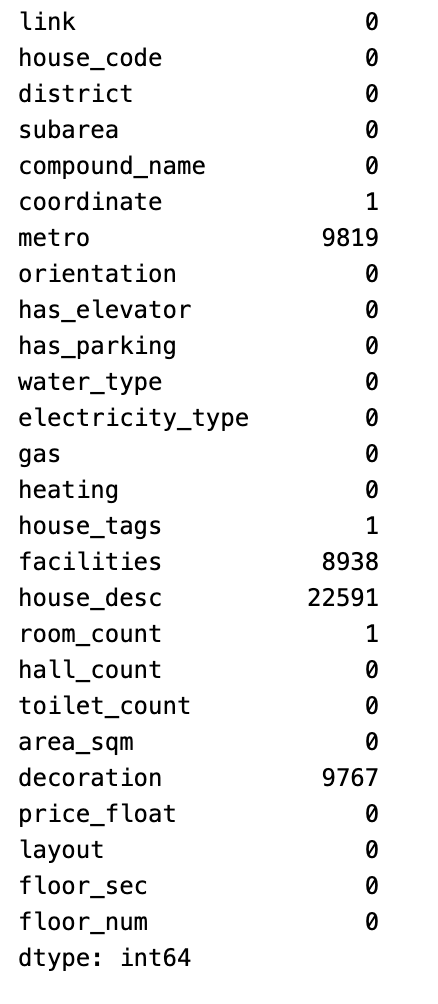

In [ ]:
# Filter the rows where either `coordinate` or `house_tags` is null
mask = df['coordinate'].isnull() | df['house_tags'].isnull()| df['room_count'].isnull()

# Select the rows that satisfy the above condition
result = df[mask]

# Print the resulting houses that contains null values
result

I want to go to the link and check why above 3 houses has null values is common columns
After investigation :
1. House 20299 is invalid, I will delete this row. 
2. House 22807 is invalid,, I will delete this row
3. House 27168 is valid, but I have no idea why coordinate info is missing for this house. As the house of same compound share the same coordinate, I will fill the missing coordinate value
   of this row by copy the coordinate value of same compound '中山北路3904弄'

In [ ]:
# Delete the house code SH2873788532714389504 and SH1648570660722573312
# create a list of indices of the rows to be deleted
indices = df[(df['house_code'] == 'SH2873788532714389504') | (df['house_code'] == 'SH1648570660722573312')].index
# delete the rows with the specified indices
df.drop(indices, inplace=True)

# Fill the coordinate of house SH1732262353786896384 with the coordinate of other houses of the same compound

# find the row with missing value in 'coordinate'
missing_row = df.loc[df['coordinate'].isna()]

# fill missing value in 'coordinate' based on values in other rows with the same 'compound name'
fill_value = df.loc[df['compound_name'] == missing_row['compound_name'].iloc[0], 'coordinate'].dropna().iloc[0]
missing_row['coordinate'] = fill_value

# update the DataFrame with the filled value
df.update(missing_row)


In [ ]:
# Check the df info again 
df.info()

Below some other string type columns that contains value that can be converted into numerical parameters, I will convert them and then delete original string type columns

In [ ]:
import pandas as pd
import numpy as np

# define function to count metro stations
def count_metro_stations(row):
    if pd.isnull(row['metro']):
        return 0
    else:
        return len(eval(row['metro']))

# Define a function to count the number of facilities
def count_facilities(facilities):
    if pd.isnull(facilities):
        return 0
    else:
        return len(facilities.split(','))

if 'num_metro_stations' not in df.columns:
    # create new column to store number of metros nearby, it is derived from metro column.
    df['num_metro_stations'] = df.apply(lambda row: count_metro_stations(row), axis=1)
    # replace any NaN values with 0
    df['num_metro_stations'] = df['num_metro_stations'].fillna(0).astype(np.int64)

if 'room_count' in df.columns:
    # Convert the room counts to integer
    df['room_count'] = df['room_count'].astype(int)
if 'hall_count' in df.columns:
    df['hall_count'] = df['hall_count'].astype(int)
if 'toilet_count' in df.columns:
    df['toilet_count'] = df['toilet_count'].astype(int)

if 'floor_num_int' not in df.columns:
    # Create a new column to store digit part of floor_num string
    df['floor_num_int'] = df['floor_num'].str.extract('(\d+)', expand=False).astype(int, errors='ignore')
    # Drop the original 'floor_num' column if it exists
    df.drop('floor_num', axis=1, inplace=True, errors='ignore')

if 'longitude' not in df.columns:
    # create new columns to store for longitude and latitude value separately , as float 
    df['longitude'] = df['coordinate'].str.split(',').str[0].astype(float)
if 'latitude' not in df.columns:
    df['latitude'] = df['coordinate'].str.split(',').str[1].astype(float)
    df.drop('coordinate', axis=1, inplace=True)

if 'facilities_count' not in df.columns:
    # Apply the function to the "facilities" column and create a new column "facilities_count"
    df['facilities_count'] = df['facilities'].apply(count_facilities)

if 'price_per_sqm' not in df.columns:
    # create a new column to store rental price per square meters 
    df['price_per_sqm'] = df['price_float'] / df['area_sqm']


In [130]:
# check again to see a sample row data
df.iloc[0]

link                  http://sh.lianjia.com/zufang/SH174097200193103...
house_code                                        SH1740972001931034624
district                                                             静安
subarea                                                              彭浦
compound_name                                                  临汾路1564弄
metro                                                              None
orientation                                                           南
has_elevator                                                          无
has_parking                                                        暂无数据
water_type                                                           民水
electricity_type                                                     民电
gas                                                                   有
heating                                                             自采暖
house_tags                                                 必看好房,

I also notice that, there's some some house are tagged with '非居住', which mean non- residential, it could be office or commercial use. As the price for such rental are very different from residential apartment, which the type of apartment we are interested to analyses. So we will split the df into residential and non residential rental listings and perform the analysis on the residential part. 

In [131]:

# assuming your DataFrame is named `df`
non_residential = df[df['house_tags'].str.contains('非居住')]
residential = df[~df['house_tags'].str.contains('非居住')]

In [132]:
num_non_residential = len(non_residential)
percent_non_residential = num_non_residential / len(df) * 100
print(num_non_residential, percent_non_residential)

num_residential = len(residential)
percent_residential = num_residential / len(df) * 100
print(num_residential,percent_residential)

2049 6.594998229746693
29020 93.4050017702533


Now we can see that we are left with 29020 (93.4%) residential rental listings to deal with. The rest of 2049 (6.5%) are non-residential listings that will leave out.

In previous steps we removed and corrected some columns and values, next we can 
1. perform one-hot encoding on selected categorical variable 
2. check if there's numerical outliers, remove them if neccessary  

In [133]:
# recall column names
residential.columns

Index(['link', 'house_code', 'district', 'subarea', 'compound_name', 'metro',
       'orientation', 'has_elevator', 'has_parking', 'water_type',
       'electricity_type', 'gas', 'heating', 'house_tags', 'facilities',
       'house_desc', 'room_count', 'hall_count', 'toilet_count', 'area_sqm',
       'decoration', 'price_float', 'layout', 'floor_sec',
       'num_metro_stations', 'floor_num_int', 'longitude', 'latitude',
       'facilities_count', 'price_per_sqm'],
      dtype='object')

Plot all categorical variables in pie charts:


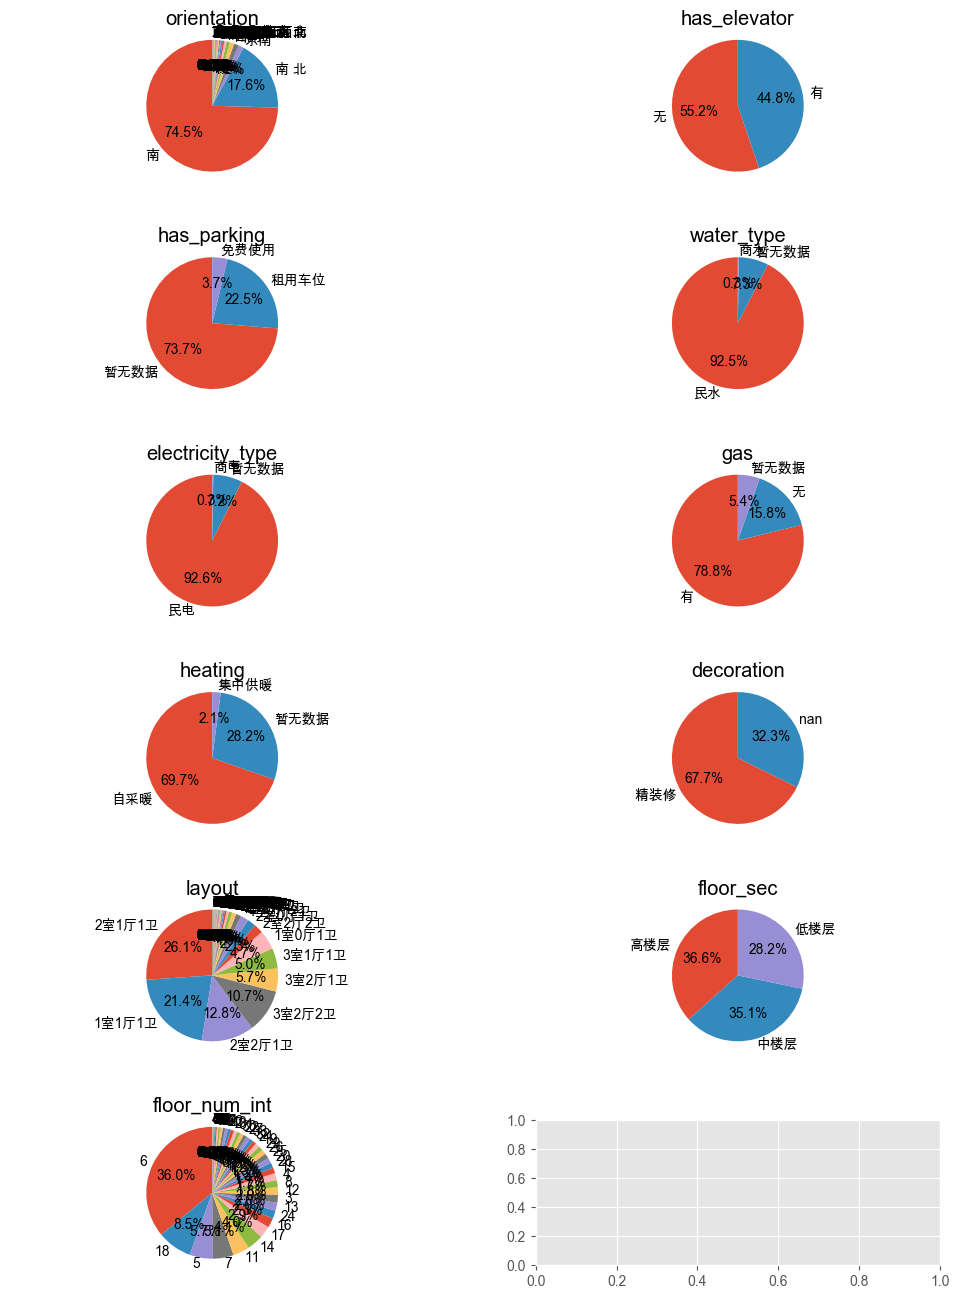

In [134]:
import matplotlib.pyplot as plt

# To plot Chinese characters correctly
plt.rcParams['font.family'] = 'Arial Unicode MS'

selected_cat_columns=['orientation', 'has_elevator', 'has_parking',
       'water_type', 'electricity_type', 'gas', 'heating', 'decoration','layout','floor_sec','floor_num_int']

# Determine the number of rows and columns for the subplot grid
n_cols = 2
n_rows = (len(selected_cat_columns) + n_cols - 1) // n_cols

# Create the subplot grid
fig, axs = plt.subplots(n_rows, n_cols, figsize=(12, 16))

# Flatten the axs array for easier indexing
axs = axs.ravel()

# Loop through each column
for i, col in enumerate(residential[selected_cat_columns]):
    # Get value counts for column
    counts = residential[col].value_counts(dropna=False)

    # Plot pie chart
    counts.plot(kind='pie', autopct='%1.1f%%', startangle=90, ax=axs[i])
    axs[i].axis('equal')
    axs[i].set_title(col)

    # Hide the y-axis labels
    axs[i].set_ylabel('')

# Adjust the spacing between subplots
plt.subplots_adjust(wspace=0.3, hspace=0.5)

# Display the plots
plt.show()


The pie chart on each categorical variable above helps me identify which categorical variable can be one-hot encoded, and which one are not: 

- Categorical variables that has too many unique values 
  -  it may not be practical to create a separate binary variable for each unique value, as this would result in too many features and potentially overfitting the model
  -  such as : `orientation`, `layout`, `floor_num_int`
- Categorical variables that has fair amount of missing values:
  - Questionable for one-hot encoding but depends on the questions. I'm comfortable filling the imput the missing values, it's better to keep the missing values as a separate category. Let's save this for later 
  - `has_parking`,`water_type`,`electricity_type`,`gas`,`heating` 
- Categorical variables that suits for one-hot encoding :
  - `has_elevator`, `decoration`,`floor_dec`

Next, let's look at if we have any numerical outliers that may affect our analysis:

In [135]:
residential.describe()

,room_count,hall_count,toilet_count,area_sqm,price_float,num_metro_stations,floor_num_int,longitude,latitude,facilities_count,price_per_sqm
count,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000,29020.000000
mean,2.077739,1.318573,1.245107,83.611848,8388.310200,2.023639,12.260476,121.442611,31.213283,4.119159,104.338291
std,0.897800,0.616122,0.558496,50.911827,8152.944782,1.618897,8.557950,0.117073,0.095975,3.228557,49.667191
min,1.000000,0.000000,0.000000,6.300000,700.000000,0.000000,1.000000,120.930790,30.718873,0.000000,6.796117
25%,1.000000,1.000000,1.000000,51.000000,4800.000000,0.000000,6.000000,121.391803,31.163857,0.000000,70.163562
50%,2.000000,1.000000,1.000000,75.050000,6200.000000,2.000000,7.000000,121.450384,31.221156,4.000000,96.595428
75%,3.000000,2.000000,1.000000,99.000000,8800.000000,3.000000,18.000000,121.511894,31.276094,7.000000,129.166980
max,9.000000,5.000000,9.000000,789.190000,240000.000000,17.000000,78.000000,121.939316,31.662014,10.000000,707.964602


First I try to use the 1.5 *IQR rule to find the outliers in numerical variables: 

In [136]:
# trynna see number of outliers in area, and price . consider if i should delete it or not 

q1 = residential[['area_sqm','price_float']].quantile(0.25)
q3 = residential[['area_sqm','price_float']].quantile(0.75)
iqr = q3 - q1

# calculate the upper and lower bounds for outliers
upper_bound = q3 + 1.5 * iqr
lower_bound = q1 - 1.5 * iqr

# identify the outliers in each column
outliers = pd.DataFrame()
for col in residential[['area_sqm','price_float']].columns:
    outliers[col] = (residential[col] < lower_bound[col]) | (residential[col] > upper_bound[col])

# print the outliers
print(outliers.sum())

area_sqm       1185
price_float    2988
dtype: int64


But I find above result is ruling out a lot valid rental data.
I will use another approach

The boxplot is suitable here to identify the numerical outliers, let's draw some:

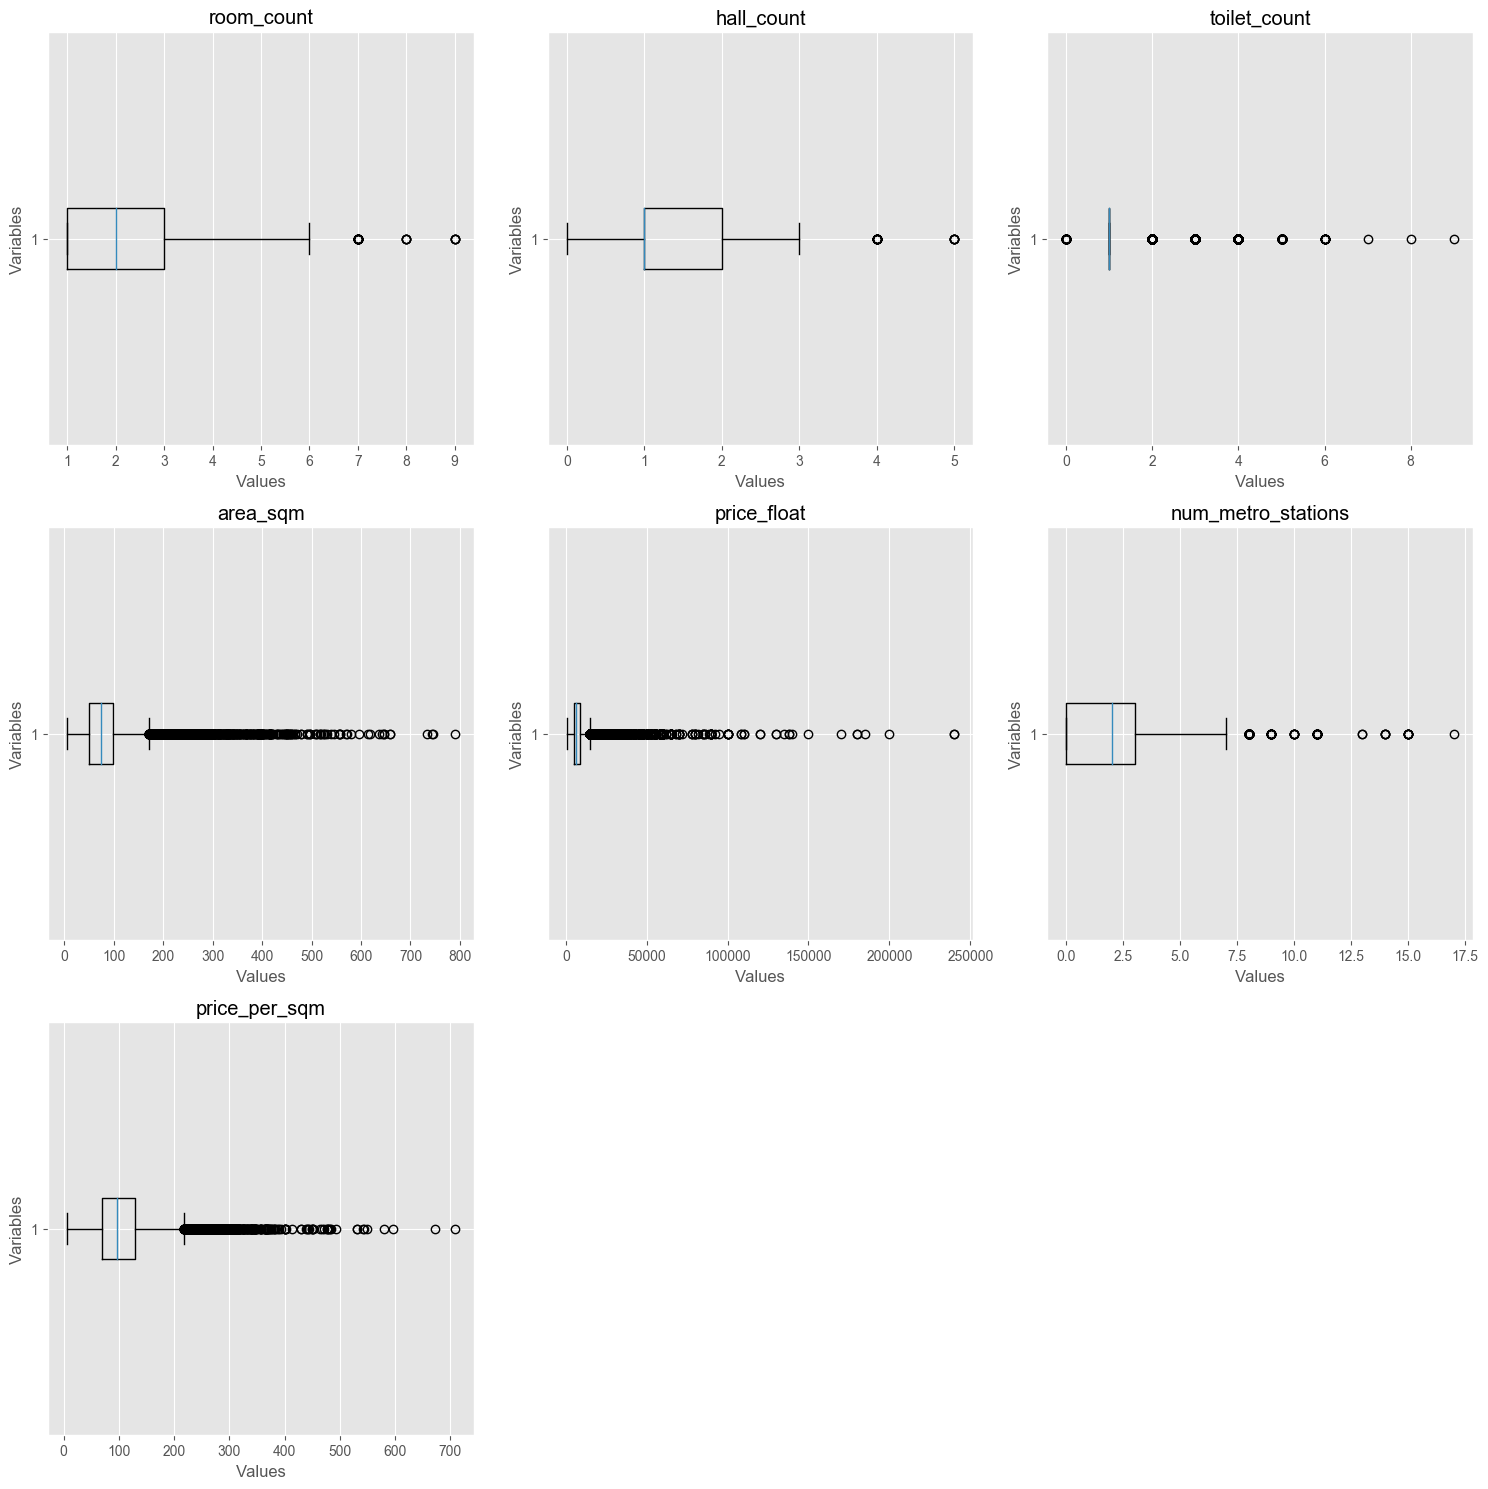

In [137]:
numeric_cols = ['room_count', 'hall_count', 'toilet_count', 'area_sqm', 'price_float', 'num_metro_stations', 'price_per_sqm']

fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))

for ax, col in zip(axs.flatten(), numeric_cols):
    ax.boxplot(residential[col].dropna(), vert=False)
    ax.set_title(col)
    ax.set_xlabel('Values')
    ax.set_ylabel('Variables')

# remove empty subplots
for i in range(len(numeric_cols), len(axs.flatten())):
    fig.delaxes(axs.flatten()[i])

plt.tight_layout()
plt.show()


We notice that there is extreme values here in area.
Let's check out these extreme values, we may need to remove these extreme values.


In [138]:
#for house rent in Shanghai, we can say that room_count>6 is rarely and unlikely.
residential[residential['room_count'] >6]

,link,house_code,district,subarea,compound_name,metro,orientation,has_elevator,has_parking,water_type,...,decoration,price_float,layout,floor_sec,num_metro_stations,floor_num_int,longitude,latitude,facilities_count,price_per_sqm
2789,http://sh.lianjia.com/zufang/SH166780024524269...,SH1667800245242691584,徐汇,植物园,石龙小区,"['3号线 ', ' 石龙路', '449m']",南,无,租用车位,暂无数据,...,精装修,38000.0,9室2厅3卫,低楼层,3,3,121.451545,31.163774,5,200.739567
10251,http://sh.lianjia.com/zufang/SH172399442264902...,SH1723994422649028608,浦东,塘桥,蓝村大厦,"['4号线,6号线 ', ' 蓝村路', '18m'],['4号线,6号线 ', ' 浦电路...",南,有,暂无数据,民水,...,NaN,14500.0,9室0厅1卫,高楼层,3,28,121.534363,31.217291,1,97.814355
11546,http://sh.lianjia.com/zufang/SH169288642037022...,SH1692886420370227200,宝山,杨行,万业紫辰苑,None,南,有,暂无数据,民水,...,NaN,7500.0,7室1厅2卫,低楼层,0,21,121.442506,31.405518,2,46.801872
15187,http://sh.lianjia.com/zufang/SH160470051687130...,SH1604700516871307264,杨浦,新江湾城,建德国际公寓,None,南,有,免费使用,民水,...,精装修,32000.0,7室3厅4卫,高楼层,0,12,121.532875,31.340577,10,131.937000
15471,http://sh.lianjia.com/zufang/SH160034798180080...,SH1600347981800800256,杨浦,新江湾城,银亿领墅,"['18号线 ', ' 殷高路', '600m'],['10号线(新江湾城-虹桥火车站),1...",南,无,免费使用,民水,...,精装修,35000.0,7室2厅5卫,低楼层,4,3,121.504989,31.321216,4,89.743590
19091,http://sh.lianjia.com/zufang/SH173125001215265...,SH1731250012152659968,嘉定,外冈,外冈新苑,None,南,无,暂无数据,民水,...,精装修,14000.0,9室3厅9卫,高楼层,0,6,121.168288,31.371104,7,60.927844
19342,http://sh.lianjia.com/zufang/SH173340128557242...,SH1733401285572427776,崇明,陈家镇,三湘海尚云邸,None,南,无,暂无数据,民水,...,精装修,27000.0,7室3厅6卫,低楼层,0,1,121.840334,31.464170,10,81.887662
19358,http://sh.lianjia.com/zufang/SH166993832830199...,SH1669938328301993984,崇明,陈家镇,览海高尔夫别墅,None,南 北,无,免费使用,民水,...,精装修,32000.0,7室2厅5卫,低楼层,0,3,121.825446,31.468048,10,91.967237
19818,http://sh.lianjia.com/zufang/SH165189628375492...,SH1651896283754921984,松江,新桥,九城家天下新座,"['12号线 ', ' 顾戴路', '96m'],['12号线 ', ' 虹莘路', '93...",南,无,暂无数据,民水,...,精装修,28000.0,7室3厅4卫,低楼层,2,3,121.312757,31.059123,10,69.560033
19857,http://sh.lianjia.com/zufang/SH173376727272128...,SH1733767272721285120,松江,松江大学城,绿地云峰名邸(别墅),None,南,无,暂无数据,暂无数据,...,精装修,15000.0,7室2厅6卫,低楼层,0,3,121.195463,31.052041,6,46.168052


In [139]:
# Remove the data that has more than 6 bedrooms 
mask = residential['room_count'] <= 6

# select only the rows that match the mask
residential = residential[mask]
residential.describe()

,room_count,hall_count,toilet_count,area_sqm,price_float,num_metro_stations,floor_num_int,longitude,latitude,facilities_count,price_per_sqm
count,28990.000000,28990.000000,28990.000000,28990.000000,28990.000000,28990.000000,28990.000000,28990.000000,28990.000000,28990.000000,28990.000000
mean,2.072232,1.317696,1.241945,83.379316,8367.608210,2.024836,12.266368,121.442644,31.213306,4.119145,104.350015
std,0.881482,0.614878,0.546660,50.313262,8104.598712,1.618779,8.556370,0.116960,0.095947,3.228169,49.657164
min,1.000000,0.000000,0.000000,6.300000,700.000000,0.000000,1.000000,120.930790,30.718873,0.000000,6.796117
25%,1.000000,1.000000,1.000000,51.000000,4800.000000,0.000000,6.000000,121.391903,31.163903,0.000000,70.186247
50%,2.000000,1.000000,1.000000,75.000000,6200.000000,2.000000,7.000000,121.450397,31.221250,4.000000,96.604005
75%,3.000000,2.000000,1.000000,99.000000,8800.000000,3.000000,18.000000,121.511857,31.276183,7.000000,129.166667
max,6.000000,5.000000,6.000000,789.190000,240000.000000,17.000000,78.000000,121.939316,31.662014,10.000000,707.964602


Up till now, we've finished preliminary data cleaning for analysis.

# Implementation

Now after above steps of data exploration and data prepocessing, we have roughly correct data format and normal value to start look at do some analysis and answer some statistical questions:


1. What is the relationship between area of a property and its rental price ?

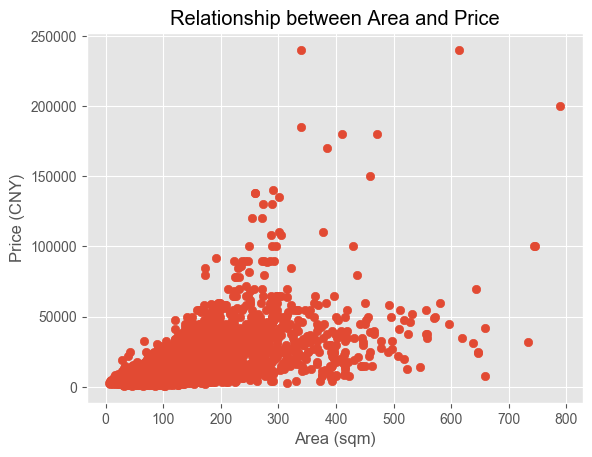

In [140]:
# Plot price against area
plt.scatter(residential['area_sqm'], residential['price_float'])
plt.xlabel('Area (sqm)')
plt.ylabel('Price (CNY)')
plt.title('Relationship between Area and Price')
plt.show()


From above chart, we can see that:  
1. In general, the rental price increases as house area increases. 
2. Most of then rental are distributed in area <400.

2. What is the distribution of rental prices? 

<Axes: ylabel='Frequency'>

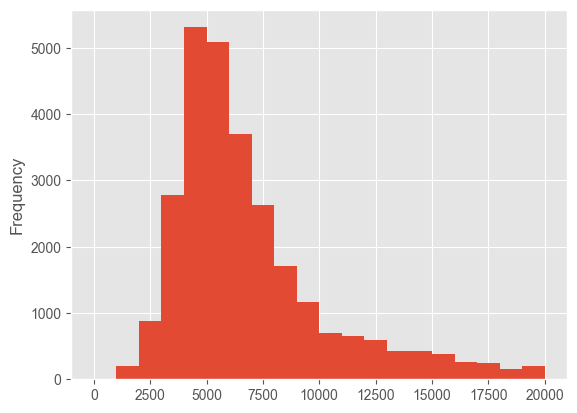

In [141]:
# plot price histogram 
pd.to_numeric(residential["price_float"]).plot.hist(bins=20, range=(1,20000))

We can see majority of the rental listings are between 4000 to 7500 RMB.

3. What is the distribution of the area in rental properties? What is the relationship between the area and the rental price per unit area? 

In [142]:
# According to the convention, I split the area of an apartment to several levels

# Define bin edges and labels
bins = [0, 50, 70, 90, 110, 130, 150, float('inf')]
labels = ['<50', '50-70', '70-90', '90-110', '110-130', '130-150', '>=150']

# Use pd.cut() to create area_level column
residential['area_level'] = pd.cut(residential['area_sqm'], bins=bins, labels=labels)

{'110-130': 89.75534667619279, '130-150': 104.11796938066527, '50-70': 100.61670244987643, '70-90': 79.89459001486671, '90-110': 87.34185008530024, '<50': 139.21974954261466, '>=150': 124.15802586677978}


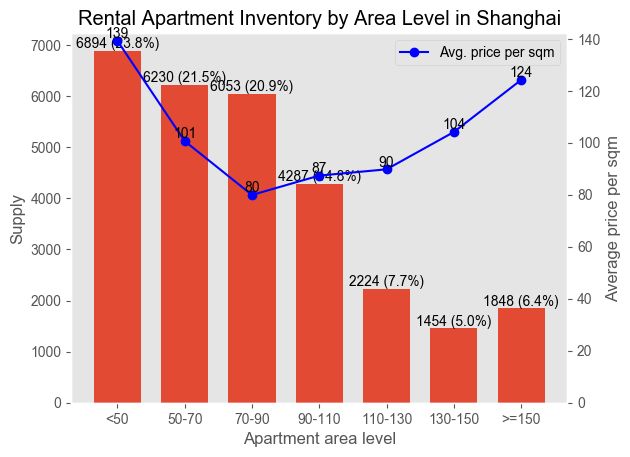

In [143]:
# Create a dictionary to store the average price per square meter for each area level
avg_price_dict = {}
for area_level in residential['area_level'].unique():
    avg_price_dict[area_level] = residential[residential['area_level'] == area_level]['price_per_sqm'].mean()

# Sort the dictionary by the keys (area levels)
avg_price_dict = {k: v for k, v in sorted(avg_price_dict.items(), key=lambda item: item[0])}

print (avg_price_dict)
# Get the x-axis tick locations and labels
xticks = np.arange(len(avg_price_dict))
xlabels = list(avg_price_dict.keys())

# Define the desired order of the x-axis labels
label_order = ['<50', '50-70', '70-90', '90-110', '110-130', '130-150', '>=150']
xlabels = [label for label in label_order if label in xlabels]

# Get the average prices and counts for each area level
avg_prices = [avg_price_dict[label] for label in xlabels]
counts = residential['area_level'].value_counts().loc[xlabels]

# Calculate the percentages
percentages = counts / len(residential) * 100

# Plot the distribution of apartments by area level
fig, ax = plt.subplots()
ax.bar(xticks, counts, align='center', width=0.7)
ax.set_xlabel('Apartment area level')
ax.set_ylabel('Supply')
ax.set_title('Rental Apartment Inventory by Area Level in Shanghai')
ax.set_ylim(bottom=0)

# Add annotations to the bars
for i, count in enumerate(counts):
    ax.annotate(f"{count} ({percentages[i]:.1f}%)", xy=(i, count), ha='center', va='bottom')

# Set the x-axis labels
ax.set_xticks(xticks)
ax.set_xticklabels(xlabels)

# Add a secondary y-axis for the average prices
ax2 = ax.twinx()
ax2.plot(xticks, avg_prices, 'bo-', label='Avg. price per sqm')
ax2.set_ylabel('Average price per sqm')
ax2.set_ylim(bottom=0)


# Add annotations to the average price points
for i, price in enumerate(avg_prices):
    ax2.annotate(f"{price:.0f}", xy=(i, price), ha='center', va='bottom')

# Show the legend
ax2.legend()
ax.grid(False)
ax2.grid(False)
plt.show()



From above chart, we can see that:
1. When looking at the residential rental apartment supply by area levels, the most popular rental apartment supply is the apartment that is less than 50 square meters, and then as the area size increases,  the lesser the supply. It is understandable in that in big cities like Shanghai (Tokyo. Hong Kong), the housing price is super high, so small to medium sized apartment are most popular. But there's an exception in the bar chart trend, the rental supplies for 'area>=150' is higher than that of '130-150', it could be that there may be more options for larger living spaces (such as villas or townhouses), which may be preferred by some residents over apartments. This could result in a decline in supply of rental apartment in those areas.
2. As for the variation in price per square meter for different area levels,  originally my expectation is that the larger the area, the lower the unit price will be, it's interesting to see that for the price per meter are high in both ends and dips in the middle. It is also understandable after reflection, the total rental price for smaller apartment are lower, it's mostly young workforce renting houses (most single or young couple), therefore there's more demand for smaller apartment, plus there's more small apartment in the city center, and city center prices are higher, so the rental that is less than 50 are most expensive in unit price. The unit price goes down as area increases, it is pretty intuitive. However, the unit price increases again, after passing 90 square meters, when making an educated guess, it could be because of that the apartment larger than 90 square meters are not mere 'economic' apartment that' just for living any more, it is for quality living, which could include rooms other than just sleeping. And further down the spectrum, for houses that;s larger than 150 square meters, they could be in luxurt.
3. My getaway from reading this chart is that if I were to rent an apartment, I will consider 70-90 which yields fairer unit price. 

4. What is the average rental price per square meter in each district?

In [ ]:
residential.shape

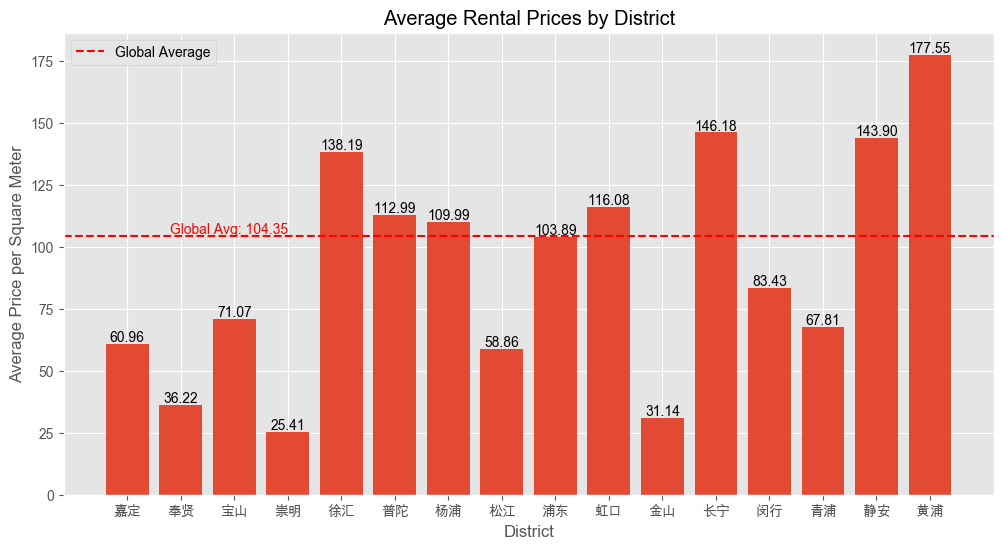

In [144]:
# group by district and calculate average price per square meter
district_price = residential.groupby('district')['price_per_sqm'].mean()

# calculate global average price per square meter
global_avg_price = residential['price_per_sqm'].mean()

# plot bar chart of district average prices with global average line
plt.figure(figsize=(12,6))
plt.bar(district_price.index, district_price.values)
plt.axhline(y=global_avg_price, color='r', linestyle='--', label='Global Average')
plt.xticks(rotation=0, ha='center')  # rotate labels and set horizontal alignment
plt.xlabel('District')
plt.ylabel('Average Price per Square Meter')
plt.title('Average Rental Prices by District')
plt.legend()

# add values to each bar
for i, v in enumerate(district_price.values):
    plt.text(i, v+1, '{:.2f}'.format(v), ha='center')

# add value for global average line
plt.text(len(district_price)*0.05, global_avg_price+1, 'Global Avg: {:.2f}'.format(global_avg_price), color='r')

plt.show()


From the chart, we can see that:
1. Average rental price per sqm in Shanghai is 104.35 RMB/sqm
2. Highest is Huangpu, which is the city center, followed by Changning, Jingan, Xuhui, Hongkou.
3. The lowest 3 is Fenxgxian, Jinshan and Chongming.
In conlusion, the average rental price per sqm is largely related to the proximity to Puxi city center.

4. What is the distribution of the number of rental properties in each district? What is the relationship between the number of properties each district and the rental price per unit area?

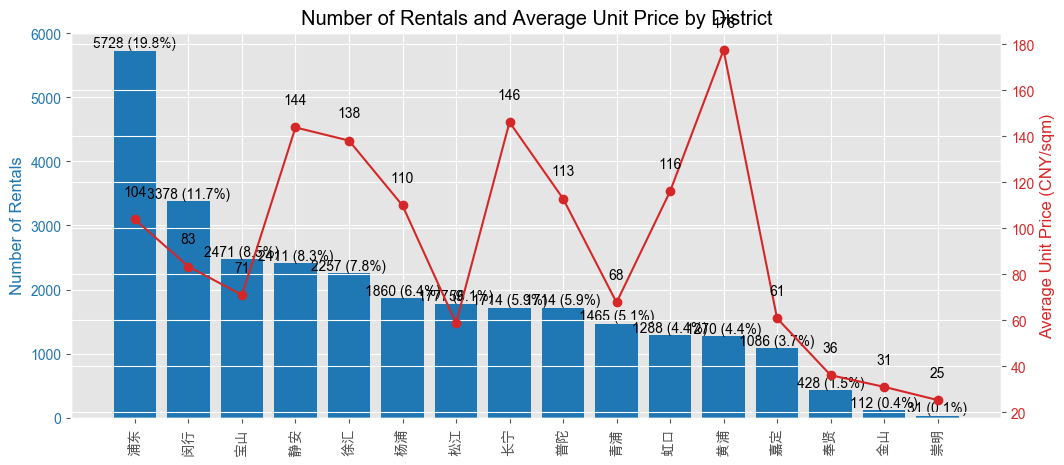

In [145]:
# Calculate the number of rentals and average unit price by district
district_counts = residential['district'].value_counts()
district_prices = residential.groupby('district')['price_per_sqm'].mean()
# Sort the districts by the number of rentals in descending order
sorted_districts = district_counts.sort_values(ascending=False).index

# Plot the number of rentals by district as bars
plt.style.use('ggplot')
fig, ax1 = plt.subplots(figsize=(12, 5))
ax1.bar(sorted_districts, district_counts[sorted_districts], color='tab:blue')
ax1.set_ylabel('Number of Rentals', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')
plt.xticks(rotation=90)

# Plot the average unit price by district as a line
ax2 = ax1.twinx()
ax2.plot(sorted_districts, district_prices[sorted_districts], 'o-', color='tab:red')
ax2.set_ylabel('Average Unit Price (CNY/sqm)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add text labels for the number of rentals and percentages on top of bars
total_rentals = district_counts.sum()
for i, district in enumerate(sorted_districts):
    count = district_counts[district]
    percent = count / total_rentals * 100
    ax1.text(i, count+50, f'{count} ({percent:.1f}%)', ha='center')
    
# Add text labels for the values of each line dot
for i, price in enumerate(district_prices[sorted_districts]):
    ax2.text(i, price+10, f'{price:.0f}', ha='center')

plt.title('Number of Rentals and Average Unit Price by District')
plt.show()


In [146]:
# Try also plot the number of rental properties of each district on a Map
from pyecharts.charts import Map
from pyecharts import options as opts

# Calculate the number of rentals and average unit price by district
district_counts = residential['district'].value_counts()

district_prices = residential.groupby('district')['price_per_sqm'].mean()

# Modify district names in district_counts variable
district_counts = district_counts.rename(lambda x: x+'新区' if x == '浦东' else x+'区')
# Modify district names in district_prices variable
district_prices = district_prices.rename(lambda x: x+'新区' if x == '浦东' else x+'区')

# Create a Map chart using pyecharts
map_chart = Map()
map_chart.set_global_opts(
    title_opts=opts.TitleOpts(title='Number of Rentals and Average Unit Price by District'),
    tooltip_opts=opts.TooltipOpts(
        formatter='{b}<br/>Number of Rentals: {c}<br/>'
    ),
    legend_opts=opts.LegendOpts(is_show=True)
)
# Add series to the chart for the number of rentals and average unit price by district
map_chart.add(
    series_name='Number of Rentals',
    data_pair=[(district, count) for district, count in district_counts.items()],
    maptype='上海'
)
# Render the chart
map_chart.render_notebook()

From above chart and map, we can see that: 
1. In terms of number of rental properties, it's interesting to see that the order in Histogram is **浦东 >闵行>宝山>静安**>徐汇>杨浦>松江>长宁>普陀>青浦>虹口>黄浦>嘉定>奉贤>金山>崇明.
I'm thinking that maybe the area of the district affects how many available rents are in each district, so I went to check 2022 Shanghai Statistical Year Book, and find the data of each district's area, resident population, population density.   
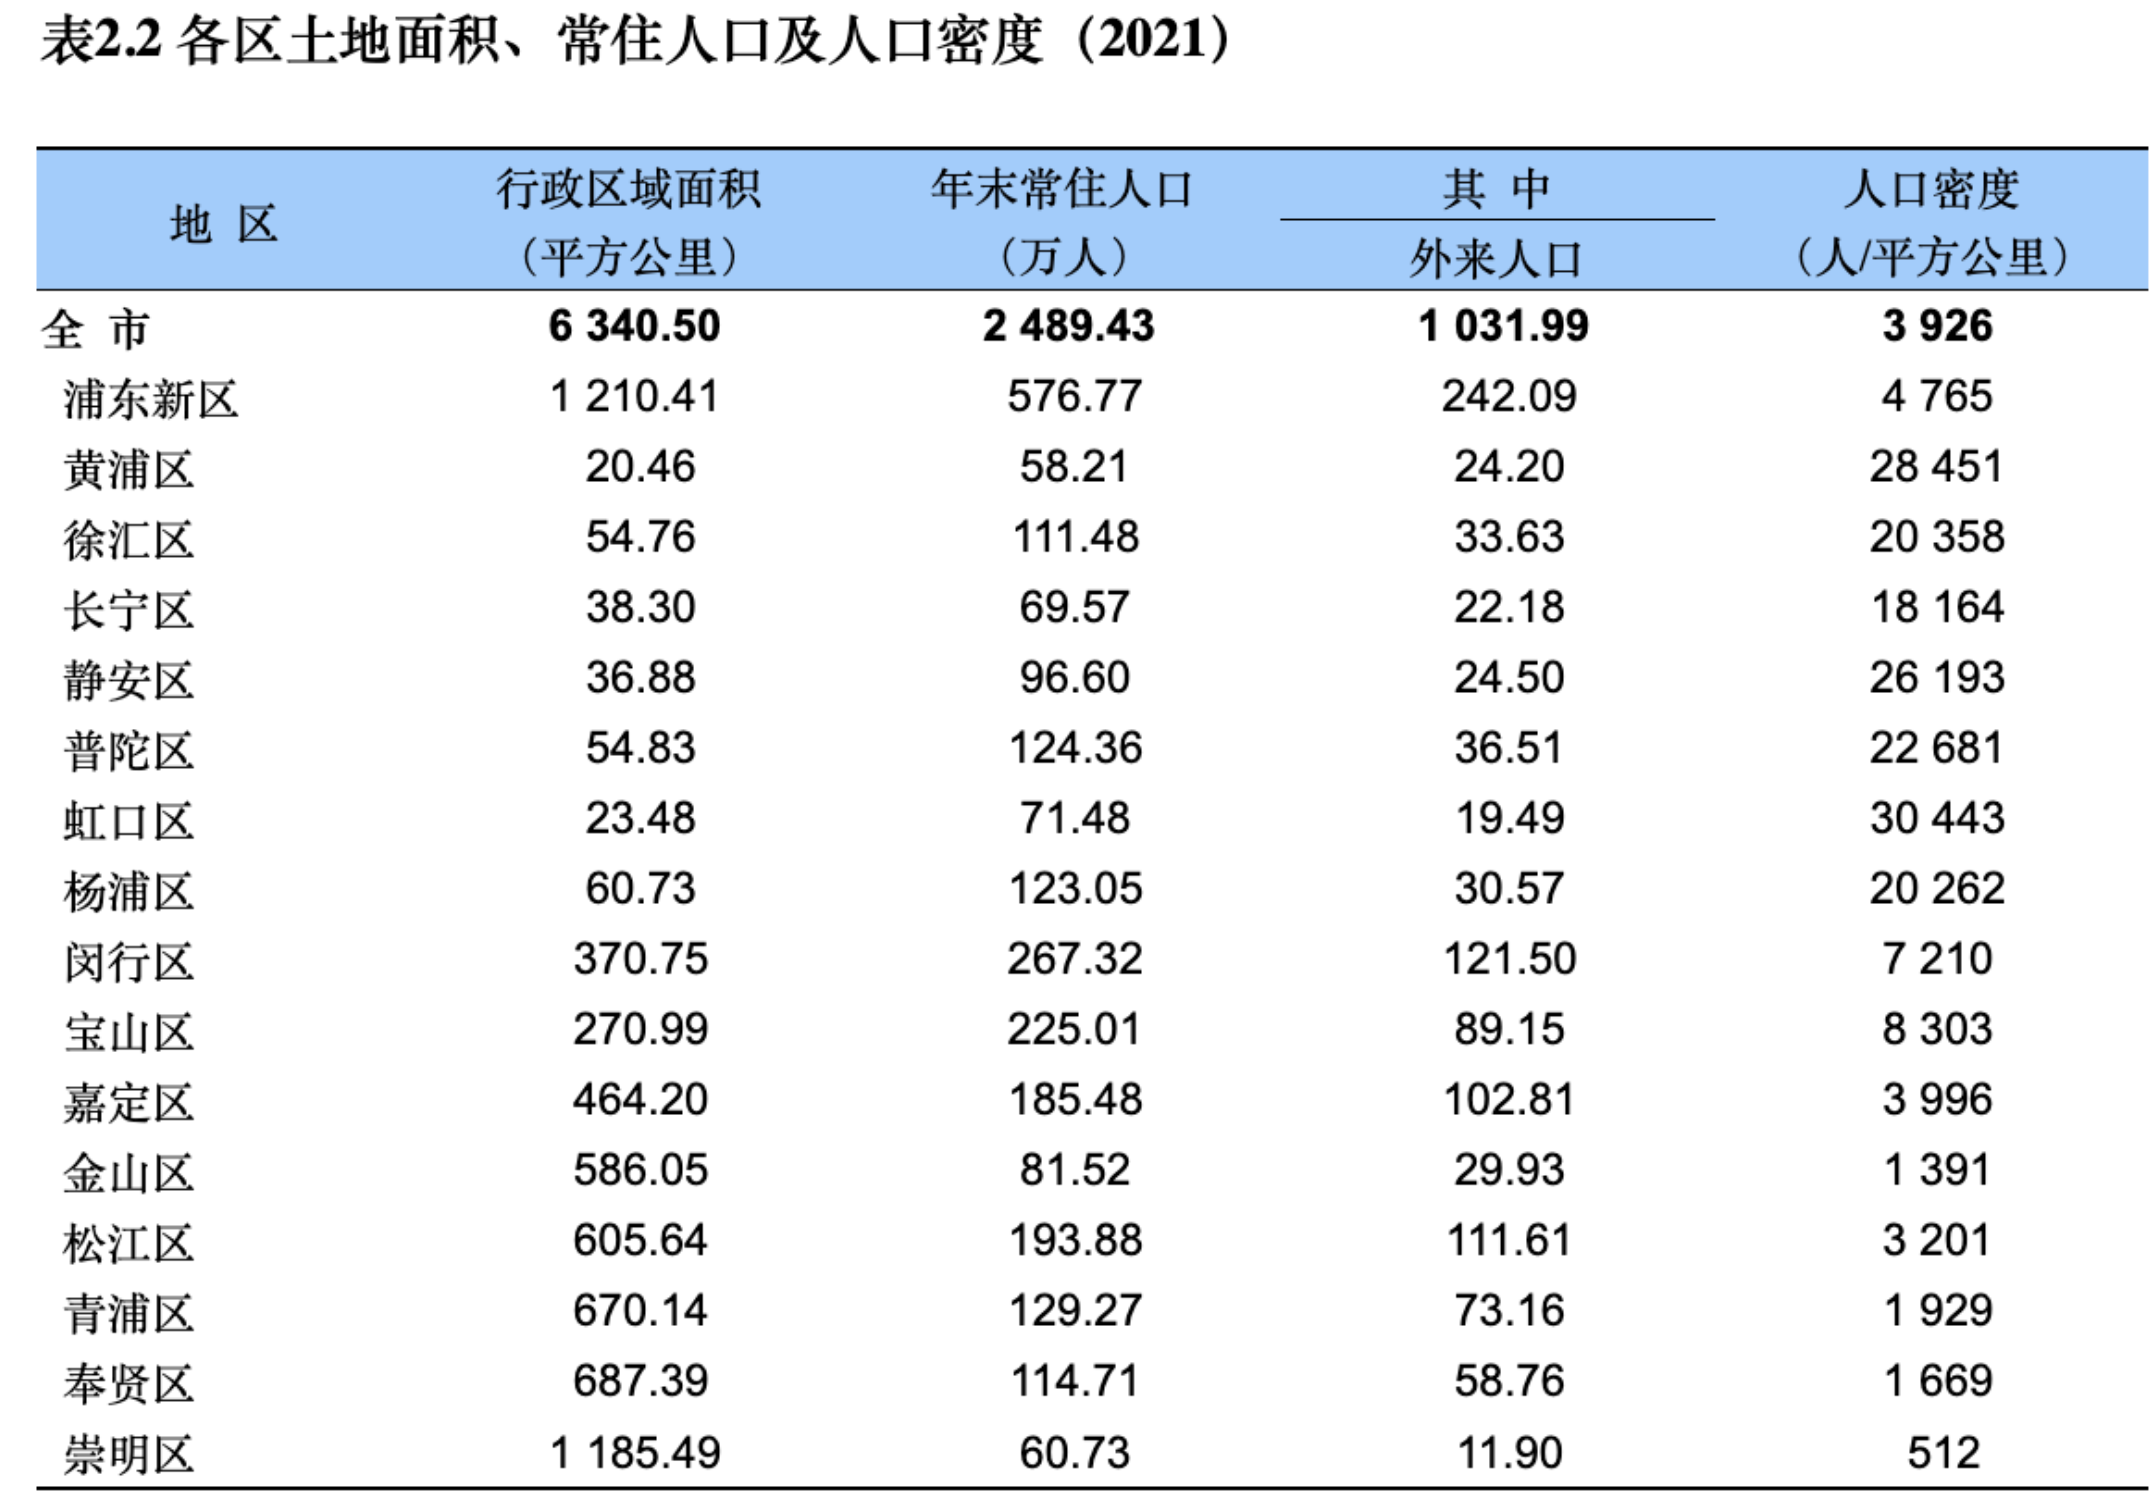

After inspecting the data, I find that the number of rent houses available each district is more related to the resident population of the district than to the area. 

2. In terms of unit price by district, it comes no surprise that **黄浦>长宁>静安>徐汇**>虹口>杨浦>浦东>闵行>宝山>青浦>松江>嘉定>奉贤>金山>崇明
It seems to me that the unit price varies to the distance to the city center , the district that's closer to city center has higher unit price that those are further away. 


5. Which districts and subareas have the highest and lowest rental prices?

In [147]:
# Group the data by district and subarea and calculate the mean rental price
grouped_price= residential.groupby(['district', 'subarea'])['price_float'].mean()

grouped_unit_price = residential.groupby(['district', 'subarea'])['price_per_sqm'].mean()
# Sort the groups by mean rental price in descending order
sorted_grouped = grouped_price.sort_values(ascending=False)
sorted_grouped_unit_price= grouped_unit_price.sort_values(ascending=False)

# Print the top 10 districts and subareas with the highest mean rental prices
print("Top 10 districts and subareas with the highest mean rental prices:")
print(sorted_grouped.head(10))

print("Top 10 districts and subareas with the highest mean unit rental prices:")
print(sorted_grouped_unit_price.head(10))

# Print the top 10 districts and subareas with the lowest mean rental prices
print("\nTop 10 districts and subareas with the lowest mean rental prices:")
print(sorted_grouped.tail(10))

print("\nTop 10 districts and subareas with the lowest mean unit rental prices:")
print(sorted_grouped_unit_price.tail(10))


Top 10 districts and subareas with the highest mean rental prices:
district  subarea
黄浦        黄浦滨江       31309.615385
          新天地        27602.343750
徐汇        徐汇滨江       27578.600000
黄浦        老西门        25551.011364
浦东        联洋         20683.333333
黄浦        豫园         19011.290323
长宁        古北         18573.326667
崇明        崇明其它       18000.000000
杨浦        新江湾城       17447.422680
闵行        金虹桥        17225.480769
Name: price_float, dtype: float64
Top 10 districts and subareas with the highest mean unit rental prices:
district  subarea
黄浦        新天地        228.394492
          淮海中路       213.642515
徐汇        建国西路       208.042614
          衡山路        207.128837
黄浦        黄浦滨江       196.980336
          老西门        195.777227
静安        静安寺        195.615618
徐汇        徐汇滨江       187.905618
静安        南京西路       187.893356
黄浦        南京东路       180.270040
Name: price_per_sqm, dtype: float64

Top 10 districts and subareas with the lowest mean rental prices:
district  subarea
金山        

6. Which subarea has the most apartment supply ? It may be easier to find apartment there as there are more choices.

In [148]:
counts = residential.groupby(['district', 'subarea']).size().reset_index(name='count')
# sort the values by count in descending order
counts = counts.sort_values(by='count', ascending=False)

# print the counts
print(counts.head(10))


    district subarea  count
163       青浦      徐泾    629
46        徐汇     徐家汇    623
142       闵行      华漕    493
132       长宁    中山公园    473
83        松江      泗泾    464
89        浦东      世博    444
34        宝山      顾村    438
172       静安    南京西路    418
173       静安      大宁    400
68        杨浦      中原    361


7. Which apartment complexes or buildings have the highest and lowest rental prices per square meter?


In [149]:
# I also want to know the average price_per_sqm for each compound and see which compound has the highest and lowest price

df_count = residential.groupby(['district', 'subarea', 'compound_name'])['price_per_sqm'].mean().reset_index()
df_count['count'] = residential.groupby(['district', 'subarea', 'compound_name'])['price_per_sqm'].count().values
df_count = df_count.sort_values(by='price_per_sqm', ascending=False).reset_index(drop=True)

print(df_count.head(10))

print(df_count.tail(10))


  district subarea compound_name  price_per_sqm  count
0       徐汇     衡山路        高安路55号     673.042862      1
1       黄浦    淮海中路        长乐路47弄     541.401274      1
2       黄浦     新天地        翠湖天地五期     511.285836      5
3       长宁    中山公园          兴安小区     484.326252      1
4       闵行     金虹桥          古北壹号     481.298014      4
5       静安    南京西路         郑家巷小区     480.000000      1
6       长宁     镇宁路            兰庭     477.011705      1
7       徐汇     衡山路       高安路103号     476.190476      1
8       徐汇    建国西路      襄阳南路389弄     451.943356      1
9       黄浦    黄浦滨江       融创外滩壹号院     449.003557      1
     district subarea  compound_name  price_per_sqm  count
8091       崇明     陈家镇  裕鸿佳苑(裕国路328弄)      14.001263      2
8092       崇明    崇明新城           风清雅苑      13.644264      2
8093       奉贤      海湾         棕榈滩海景城      13.008976      1
8094       浦东     万祥镇          万祥兴隆苑      12.420432      1
8095       奉贤      海湾          嘉业海悦苑      11.704618      1
8096       青浦     朱家角            嘉涛湾     

8. What is the most common type of apartment layout (number of bedrooms, bathrooms, etc.) overall , and in each district?

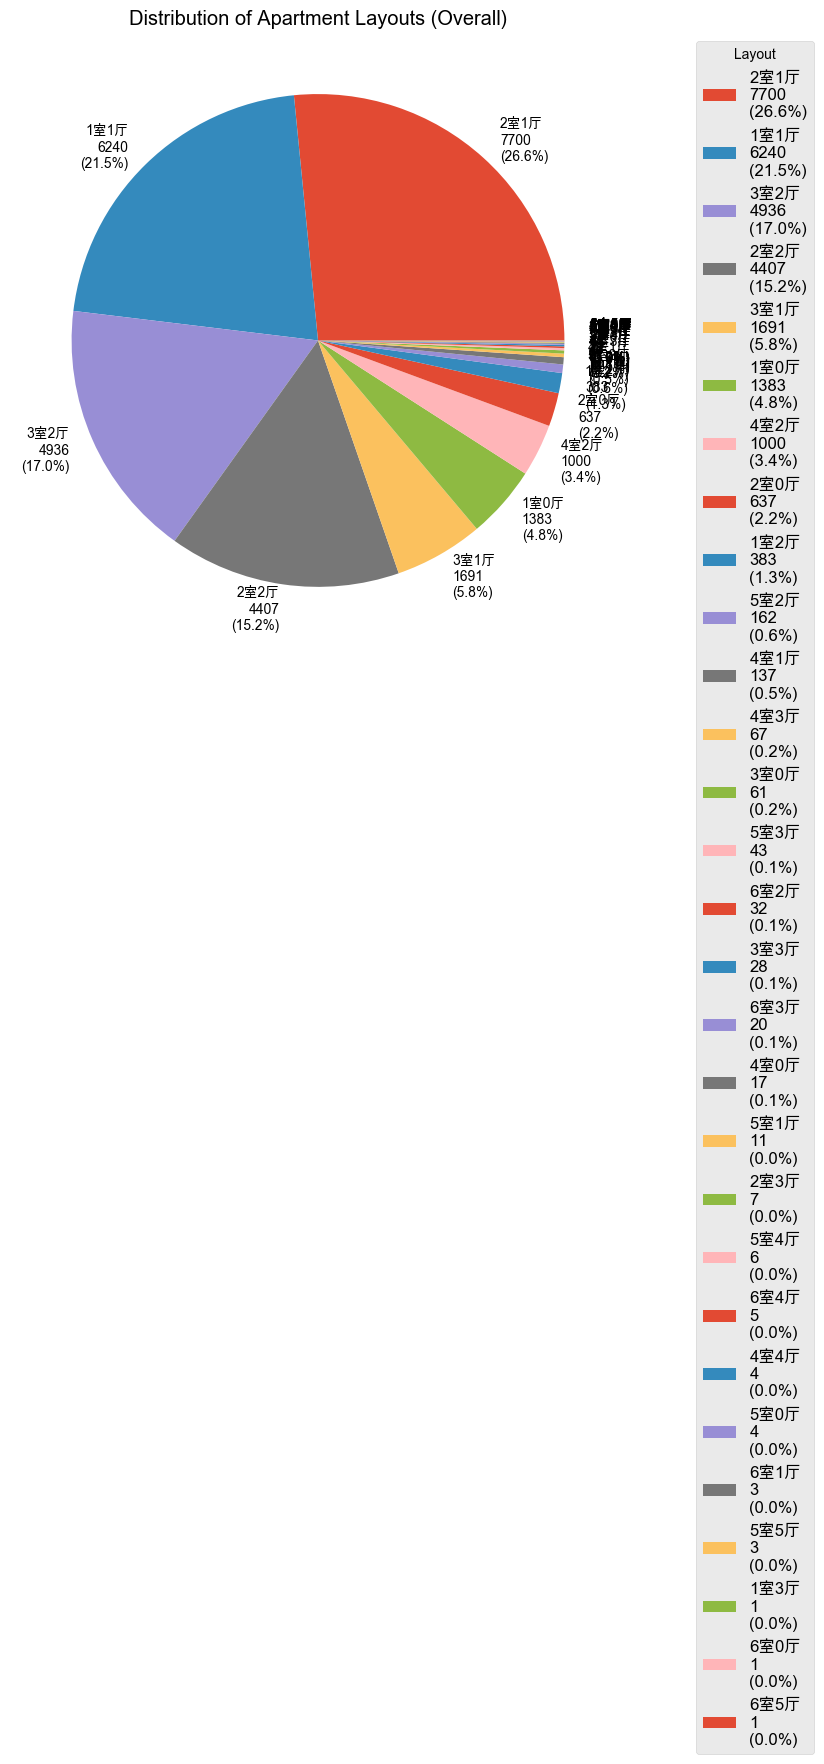

In [150]:

# create a new column 'bed_liv_room' based on the 'layout' column
if 'bed_liv_room' not in residential.columns:
    residential['bed_liv_room'] = residential['layout'].str.extract(r'(\d+室\d+厅)')

# get the overall count and percentage of apartment layouts
overall_counts = residential['bed_liv_room'].value_counts()
overall_percentages = 100 * overall_counts / len(residential)

# plot pie chart for overall distribution
total = overall_counts.sum()
labels = [f"{label}\n{count}\n({100 * count/total:.1f}%)" for label, count in zip(overall_counts.index, overall_counts)]
fig, ax = plt.subplots(figsize=(8, 8))
ax.pie(overall_counts, labels=labels, autopct='')
ax.set_title('Distribution of Apartment Layouts (Overall)')

# set legend and adjust font size
legend = plt.legend(title='Layout', bbox_to_anchor=(1.1, 1), loc='upper left', fontsize='12')
plt.setp(legend.get_texts(), fontsize='12')
plt.show()


We can see that the 10 most popular rental apartment layout in the rent market are:

| Bed_Liv_Room | Percentage (%) |
| --- | ---: |
| 2室1厅 | 26.560883 |
| 1室1厅 | 21.524664 |
| 3室2厅 | 17.026561 |
| 2室2厅 | 15.201794 |
| 3室1厅 | 5.833046 |
| 1室0厅 | 4.770611 |
| 4室2厅 | 3.449465 |
| 2室0厅 | 2.197309 |
| 1室2厅 | 1.321145 |
| 5室2厅 | 0.558813 |



It is pretty understandable that in metropolitan city like Shanghai, due to the limited land resources and increasing population density, most houses are designed in medium and small sizes. 

For the top one ,2室1厅, 2 bedroom 1 living room , suitable for medium-sized families  
For the 2nd one, 1室1厅, 2 bedroom 1 living room, suitable for single individuals, young couples, and small families  
For the 3rd one, 3室2厅, 3 bedroom 2 living room, suitable for larger families or people with more demand for space  

Additionally, according to a report by E-house China R&D Institute, one-bedroom and two-bedroom apartments accounted for around 70% of the total new residential supply in Shanghai in 2020, while three-bedroom apartments accounted for around 20%.

I'm curious to see what't the most popular rental apartment layout in each district

In [151]:
# Group by district, and find the mode of layout type
mode_df = residential.groupby(['district'])[['room_count', 'hall_count']].agg(lambda x: x.mode()[0])

# Print the result
print(mode_df)


          room_count  hall_count
district                        
嘉定                 2           2
奉贤                 3           2
宝山                 2           1
崇明                 3           2
徐汇                 2           1
普陀                 2           1
杨浦                 2           1
松江                 3           2
浦东                 2           1
虹口                 2           1
金山                 3           2
长宁                 1           1
闵行                 2           1
青浦                 3           2
静安                 1           1
黄浦                 1           1


From above, I can see that the distrcit that's closer to city center have less bedrooms (usually 1b1r ) than those are further away from city center. It is pretty understandable as there are more mordern new buildings built in  remote area with larger area. 

9. Is there noticeable difference in price per square meters rental price for those who has description and those doesn't have ?

In [152]:
residential.shape

(28990, 32)

has_description
False     97.478912
True     122.325273
Name: price_per_sqm, dtype: float64


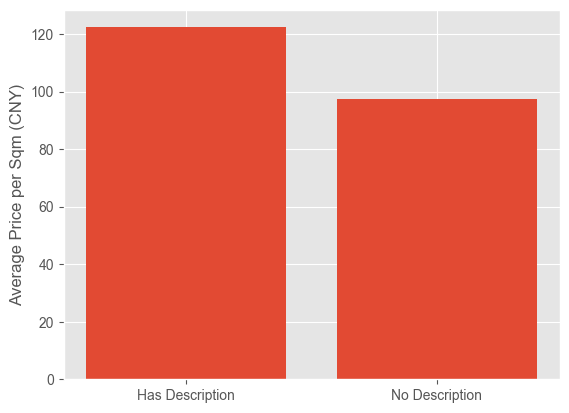

In [153]:
# Create subsets of the data with non-null and null house_description values
residential['has_description'] = residential['house_desc'].notna() & residential['house_desc'].ne("")
# Calculate the average price for each subset

avg_price_per_sqm = residential.groupby('has_description')['price_per_sqm'].mean()
print(avg_price_per_sqm)
has_desc_avg_price = avg_price_per_sqm[True]
no_desc_avg_price = avg_price_per_sqm[False]

# Plot the average prices for each subset
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.bar(['Has Description', 'No Description'], [has_desc_avg_price, no_desc_avg_price])
ax.set_ylabel('Average Price per Sqm (CNY)')
plt.show()


From above chart, we can see that rental listings that have descriptions has noticeable higher price than those that don't have. 
It might be that the rental listings with description filled are apartment that has highlight in its amenity, decorations, etc so it is filled with ample information,  and they are likely be actively maintained by agent/landlord to fill in details of the listings, therefore they are more expensive. 

10. What are some valuable insights we can draw some making a word cloud of all rental listings' description field?

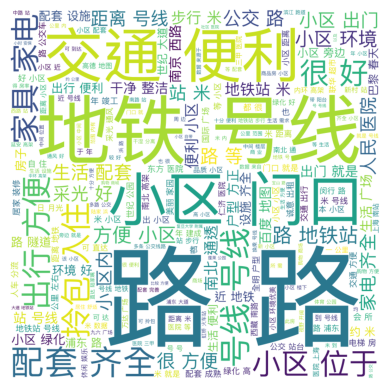

In [154]:
import jieba
from wordcloud import WordCloud
import re

# Filter out rows where the house_desc is null
df_has_desc = residential[residential['has_description'] == True]


# Define custom stop words
stop_words = [' ', '的', '了', '和', '是', '在', '有', '中', '为', '以', '及', '上', '下']

# Use jieba to segment the text and join the words together
text = ' '.join(jieba.cut(''.join(df_has_desc['house_desc']), cut_all=False, HMM=True))

# Remove words inside brackets 【】 using regular expression
text = re.sub('\【.*\】', '', text)
# Define a Chinese font
font_path = '/System/Library/Fonts/PingFang.ttc'
# Generate the word cloud
wordcloud = WordCloud(width=800, height=800, background_color='white', font_path=font_path, stopwords=stop_words).generate(text)

# Display the word cloud
plt.imshow(wordcloud)
plt.axis('off')
plt.show()


From above word cloud, I can see that “交通便利” “地铁” “配套齐全” “拎包入住” are the most frequent mentioned words. It indicates that landlord like to use 'Close to Metro', 'fully equipped and furnished' to attract tenants.

 11. How does the price per square meter vary based on the number of bedrooms or bathrooms in the apartment?

In [155]:
residential.shape

(28990, 33)

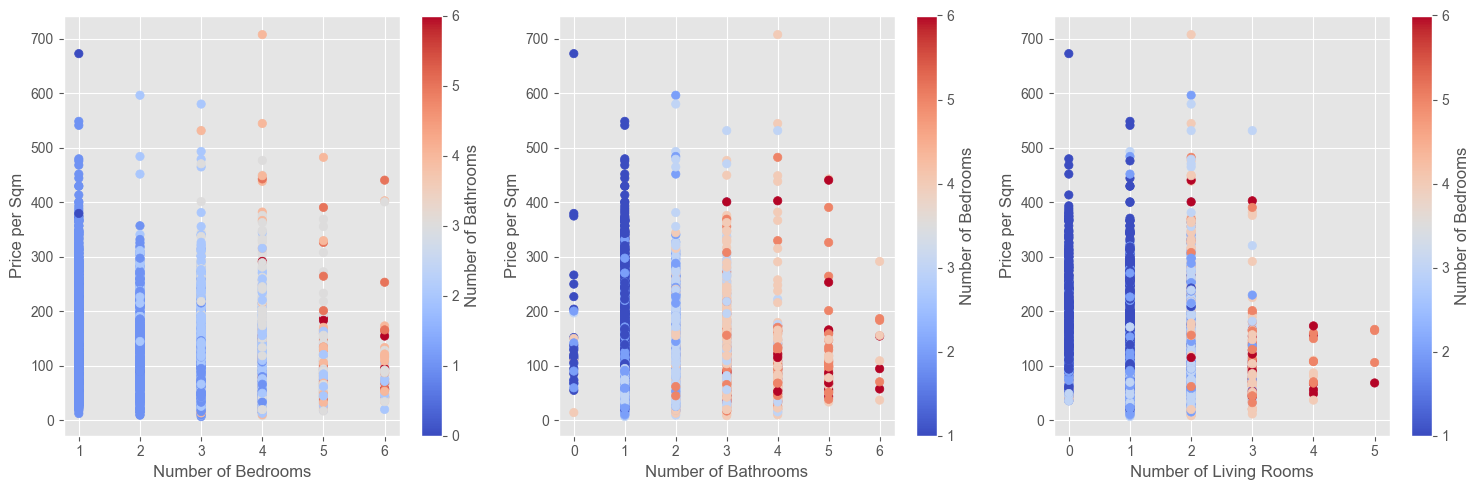

In [156]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, figsize=(15,5))

# create a scatter plot for number of bedrooms vs. price per sqm
scatter1 = ax1.scatter(residential['room_count'], residential['price_per_sqm'], c=residential['toilet_count'], cmap='coolwarm')
ax1.set_xlabel('Number of Bedrooms')
ax1.set_ylabel('Price per Sqm')
fig.colorbar(scatter1, ax=ax1, label='Number of Bathrooms')

# create a scatter plot for number of bathrooms vs. price per sqm
scatter2 = ax2.scatter(residential['toilet_count'], residential['price_per_sqm'], c=residential['room_count'], cmap='coolwarm')
ax2.set_xlabel('Number of Bathrooms')
ax2.set_ylabel('Price per Sqm')
fig.colorbar(scatter2, ax=ax2, label='Number of Bedrooms')

# create a scatter plot for number of living rooms vs. price per sqm
scatter3 = ax3.scatter(residential['hall_count'], residential['price_per_sqm'], c=residential['room_count'], cmap='coolwarm')
ax3.set_xlabel('Number of Living Rooms')
ax3.set_ylabel('Price per Sqm')
fig.colorbar(scatter3, ax=ax3, label='Number of Bedrooms')

plt.tight_layout()
plt.show()


From the chart, we can see that ：
1. There are positive correlation between number of bedroom, number of bathrooms and number of living rooms
2. There are not obvious relationship between number of room with the price per sqm. 

13. How do apartment prices vary based on the floor the apartment is on (higher or lower floors)?


<Axes: xlabel='floor_sec', ylabel='price_float'>

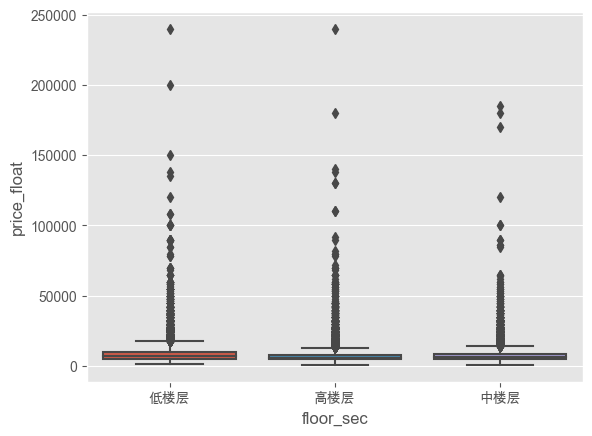

In [157]:
import seaborn as sns

sns.boxplot(x='floor_sec', y='price_float', data=residential)

The resulting plot is a box plot that shows the distribution of apartment prices for each floor section. The x-axis represents the floor section, and the y-axis represents the apartment prices. The boxes in the plot show the interquartile range (IQR), with the horizontal line inside the box representing the median. The whiskers extend to the minimum and maximum values that fall within 1.5 times the IQR from the box. Any outliers beyond the whiskers are shown as individual points.

From the plot, it appears that apartments on the middle floor section tend to have higher prices than those on the low or high floor sections. The low and high floor sections have similar price ranges and median prices, but the low floor section has more outliers with higher prices. Overall, the floor section appears to be a factor that influences apartment prices, with apartments on the middle floor section generally being more expensive.

14. Is there a correlation between the apartment's proximity to a metro station and its rental price?

To calculate the correlation, we have the rental price in `residential` dataframe, another data we need to obtain is the distance between the house and the cloest metro station, now we have the `longtitude` and `latitude` of the house position. To calculate the distance, we need to get a table of all metro stations in shanghai and their longtitude and lattitude.

I have obtained the data from the internet, formated and saved them to a table called `sh_metro_stations`. Let's load the data first.

In [158]:
# Use a context manager to handle the SQLite connection and cursor
with sqlite3.connect('./db/house_rent_lianjia.db') as conn:
    # Query the database and convert the data to a Pandas DataFrame
    stations = pd.read_sql_query("SELECT * FROM sh_metro_stations", conn)

# Have an overview of the data
stations

,id,name,lng,lat,lines
0,1,莘庄,121.385373,31.111152,"5号线, 1号线"
1,2,外环路,121.393020,31.120899,1号线
2,3,莲花路,121.402910,31.130900,1号线
3,4,锦江乐园,121.414107,31.142217,1号线
4,5,上海南站,121.430041,31.154579,"3号线, 15号线, 1号线"
...,...,...,...,...,...
579,580,三鲁公路,121.527389,31.056108,浦江线
580,581,闵瑞路,121.530323,31.047956,浦江线
581,582,浦航路,121.530591,31.040993,浦江线
582,583,东城一路,121.532093,31.030390,浦江线


First I want to examine the correlation between apartment's distance to closest metro staion and rental price.  
To further investigate how metro stations nearby will affect the rental price of a house, I also want to investigate if number of metro stations within 1km of the house will be a more significant factor in determining rental price.


In [159]:
from scipy.spatial import KDTree

# convert latitudes and longitudes to radians
residential_rad = np.radians(residential[['latitude', 'longitude']].values)
metro_coords_rad = np.radians(np.array([(s.lat, s.lng) for s in stations.itertuples()]))

# build a KDTree from the metro coordinates
metro_tree = KDTree(metro_coords_rad)

# query the KDTree to find the nearest metro station for each residential property
distances, indices = metro_tree.query(residential_rad, k=1)

# calculate the distance to the nearest metro station for each residential property
residential['dist_to_metro'] = distances * 6371

# find the metro stations within a 1km radius of each residential property
within_radius = metro_tree.query_ball_point(residential_rad, r=1/6371)

# count the number of metro stations within a 1km radius for each residential property
residential['num_metro_stations_in_1km'] = [len(x) for x in within_radius]

cor_dis_metro= residential['dist_to_metro'].corr(residential['price_float'])
print('Correlation between distance to nearest metro station and rental price: {:.2f}'.format(cor_dis_metro))

# calculate the correlation between the number of metro stations within a 1km radius and the rental price
cor_num_metro= residential['num_metro_stations_in_1km'].corr(residential['price_float'])
print('Correlation between number of metro stations within 1km radius and rental price: {:.2f}'.format(cor_num_metro))


Correlation between distance to nearest metro station and rental price: -0.12
Correlation between number of metro stations within 1km radius and rental price: 0.21


The calculated Correlation between distance to nearest metro station and rental rice: -0.12.
It indicates a weak negative correlation between distance to nearest metro station and rental price. This means that as the distance to the nearest metro station increases, there is a slight decrease in rental price, but the relationship is not very strong. Other factors likely play a more significant role in determining rental prices.

The correlation coefficient of 0.21 suggests a weak positive correlation between the number of metro stations within a 1km radius and the rental price. This means that as the number of metro stations within 1km of the house increases, the rental price tends to increase slightly. However, the correlation is not very strong, so there are likely other factors that also influence the rental price.

15. Are there certain features or amenities (such as parking or an elevator) that tend to be associated with higher rental prices?

I want to calcualte cooreation of all numerical variables with rental price to get a correlation matrix. That will make it easy to identify which variables affects rental price more. 

First, I will add a column to store the apartment distance to the city center, as I believe it will be a factor that affects rental price.    
Also, I will perform one-hot encoding on selected categorical variables so the correaltion between them and the rental price can be calculated.   


In [160]:
residential.shape

(28990, 35)

In [161]:
from math import radians, sin, cos, sqrt, atan2

# Coordinates of People's Square, which is commonly considered city center
ppl_sq_lat = 31.2304
ppl_sq_lon = 121.4737

# Haversine formula to calculate distance between two sets of coordinates
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of the Earth in km

    # Convert latitude and longitude to radians
    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    # Calculate the difference between the two latitudes and longitudes
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    # Calculate the distance using the Haversine formula
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c

    return distance

# Create a new column in the DataFrame with the distance to People's Square
residential['distance_to_ppl_sq'] = residential.apply(
    lambda row: haversine(row['latitude'], row['longitude'], ppl_sq_lat, ppl_sq_lon), axis=1)


In [162]:
residential.shape

(28990, 36)

In [163]:
residential.columns

Index(['link', 'house_code', 'district', 'subarea', 'compound_name', 'metro',
       'orientation', 'has_elevator', 'has_parking', 'water_type',
       'electricity_type', 'gas', 'heating', 'house_tags', 'facilities',
       'house_desc', 'room_count', 'hall_count', 'toilet_count', 'area_sqm',
       'decoration', 'price_float', 'layout', 'floor_sec',
       'num_metro_stations', 'floor_num_int', 'longitude', 'latitude',
       'facilities_count', 'price_per_sqm', 'area_level', 'bed_liv_room',
       'has_description', 'dist_to_metro', 'num_metro_stations_in_1km',
       'distance_to_ppl_sq'],
      dtype='object')

In [164]:
one_hot_cols = ['has_elevator', 'has_parking', 'water_type',
       'electricity_type', 'gas', 'heating', 'decoration', 'floor_sec','has_description']
residential_one_hot = pd.get_dummies(residential, columns=one_hot_cols)


In [165]:
residential_one_hot.columns

Index(['link', 'house_code', 'district', 'subarea', 'compound_name', 'metro',
       'orientation', 'house_tags', 'facilities', 'house_desc', 'room_count',
       'hall_count', 'toilet_count', 'area_sqm', 'price_float', 'layout',
       'num_metro_stations', 'floor_num_int', 'longitude', 'latitude',
       'facilities_count', 'price_per_sqm', 'area_level', 'bed_liv_room',
       'dist_to_metro', 'num_metro_stations_in_1km', 'distance_to_ppl_sq',
       'has_elevator_无', 'has_elevator_有', 'has_parking_免费使用',
       'has_parking_暂无数据', 'has_parking_租用车位', 'water_type_商水',
       'water_type_暂无数据', 'water_type_民水', 'electricity_type_商电',
       'electricity_type_暂无数据', 'electricity_type_民电', 'gas_无', 'gas_暂无数据',
       'gas_有', 'heating_暂无数据', 'heating_自采暖', 'heating_集中供暖',
       'decoration_ 精装修', 'floor_sec_中楼层', 'floor_sec_低楼层', 'floor_sec_高楼层',
       'has_description_False', 'has_description_True'],
      dtype='object')

In [170]:
residential_one_hot.dtypes

link                           object
house_code                     object
district                       object
subarea                        object
compound_name                  object
metro                          object
orientation                    object
house_tags                     object
facilities                     object
house_desc                     object
room_count                      int64
hall_count                      int64
toilet_count                    int64
area_sqm                      float64
price_float                   float64
layout                         object
num_metro_stations              int64
floor_num_int                   int64
longitude                     float64
latitude                      float64
facilities_count                int64
price_per_sqm                 float64
area_level                   category
bed_liv_room                   object
dist_to_metro                 float64
num_metro_stations_in_1km       int64
distance_to_

One hot encoded columns are in value True and False , they needs to be converted to numeric 1 and 0 in order to calcualte correation with target variable.

In [172]:
def convert_boolean_to_numeric(df):
    # Convert boolean columns to numerical form
    df_numeric = df.replace({True: 1, False: 0})
    
    # Identify non-numerical columns
    non_numerical_columns = df_numeric.select_dtypes(exclude='number').columns

    # Print non-numerical column names
    print("Non-Numerical Columns:")
    print(non_numerical_columns)
    
    return df_numeric

def calculate_correlations(df, target_column):
    # Select only numerical columns
    numerical_columns = df.select_dtypes(include=np.number)

    # Calculate correlations
    correlations = numerical_columns.corr()[target_column].sort_values(ascending=False)

    return correlations

# Convert boolean columns to numerical form
residential_one_hot_numeric = convert_boolean_to_numeric(residential_one_hot)

# Calculate correlations
correlations = calculate_correlations(residential_one_hot_numeric, 'price_float')
print(correlations)



Non-Numerical Columns:
Index(['link', 'house_code', 'district', 'subarea', 'compound_name', 'metro',
       'orientation', 'house_tags', 'facilities', 'house_desc', 'layout',
       'area_level', 'bed_liv_room'],
      dtype='object')
price_float                  1.000000
area_sqm                     0.667503
toilet_count                 0.590420
price_per_sqm                0.484629
room_count                   0.436689
hall_count                   0.370137
floor_num_int                0.319200
has_elevator_有               0.255243
has_parking_免费使用             0.238426
decoration_ 精装修              0.215047
num_metro_stations_in_1km    0.205326
has_description_True         0.196237
num_metro_stations           0.161852
floor_sec_低楼层                0.087737
gas_有                        0.086020
heating_自采暖                  0.083751
has_parking_租用车位             0.082828
facilities_count             0.076820
longitude                    0.056271
heating_集中供暖                 0.036277
latit

Here are some insights that can be drawn from the correlation table:

- Positive correlations:
    - `price_float` has a strong positive correlation with `area_sqm` (0.667503), indicating that larger properties tend to have higher prices.
    - There is a moderate positive correlation between `price_float` and `toilet_count` (0.590420), `price_per_sqm` (0.484629), `room_count` (0.436689), and `hall_count` (0.370137). This suggests that properties with more toilets, higher price per square meter, more rooms, and more halls tend to have higher prices.
    - `price_float` also shows positive correlations with features like `floor_num_int`, `has_elevator_有`, `has_parking_免费使用`, `decoration_ 精装修`, and `num_metro_stations_in_1km`, although the correlations are not as strong.

- Negative correlations:
    - There is a moderate negative correlation between `price_float` and `has_elevator_无` (-0.255243), indicating that properties without elevators tend to have lower prices compared to those with elevators.
    - `price_float` has a negative correlation with features like `has_parking_暂无数据`, `has_description_False`, `distance_to_ppl_sq`, and `dist_to_metro`, indicating that these factors might have a negative impact on property prices.
    - Other features such as `floor_sec_高楼层`, `gas_无`, and `heating_暂无数据` also show negative correlations with `price_float`, although the correlations are relatively weak.

These insights provide an understanding of how different features are related to the `price_float` column, helping identify potential factors influencing property prices, it helps identify feature set that's needed by model to predict rental price. However, it's important to note that correlation does not imply causation, and further analysis or domain knowledge may be required to establish causal relationships between the variables.


15. Can we build a model to predict the rental price of an apartment given its features, such as location, size, number of rooms, etc.?

With the correlation table we calculated before, these features have relatively high positive correlation with price_float:

- area_sqm
- toilet_count
- price_per_sqm
- room_count
- hall_count
- floor_num_int
- has_elevator_有
- has_parking_免费使用
- decoration_ 精装修
- num_metro_stations_in_1km
- num_metro_stations

Meanwhile, these features have relatively high negative correlation:

- has_elevator_无
- has_description_False
- distance_to_ppl_sq

Given these correlations, I consider using these variables as features in my model, as they could have significant influence on the rental price.

There are 2 sets of features have potential multicollinearity issue. For instance, `has_description_True` and `has_description_False` are likely perfectly negatively correlated, so including both of them in your model might cause issues. The same might apply to `has_elevator_有` and `has_elevator_无`.

In the end, i will choose this set whose correlation coeffienct >=0.2 as features: 

- area_sqm
- toilet_count
- room_count
- hall_count
- floor_num_int
- has_elevator_有
- has_parking_免费使用
- decoration_ 精装修
- num_metro_stations_in_1km
- distance_to_ppl_sq

Select initial set of features

In [174]:
# Define the initial features and target variable

features = ['area_sqm', 'toilet_count', 'room_count', 
            'hall_count', 'floor_num_int','has_elevator_有', 
            'has_parking_免费使用', 'decoration_ 精装修', 
            'num_metro_stations_in_1km', 'distance_to_ppl_sq']

target = 'price_float'


Split train and validation sets

In [175]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets

def train_test_split_new(df, features, target):

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.3, random_state=42)
    
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = train_test_split_new(residential_one_hot_numeric,features,target)

Prelimanary model performance comparison and selection

In [180]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

results_df = pd.DataFrame(columns=['Model', 'Mean Squared Error', 'Root Mean Squared Error', 'Mean Absolute Error', 'R-Squared'])

def calculate_regression_metrics(y_test, y_pred, name):
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    return [name, mse, rmse, mae, r2]

In [182]:
# Import necessary libraries
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn import svm
import xgboost as xgb

# Initialize models
lr = LinearRegression()
rf = RandomForestRegressor(random_state=42)
gb = GradientBoostingRegressor(random_state=42)
nn = Sequential()
nn.add(Dense(10, input_dim=len(features), activation='relu'))
nn.add(Dense(1, activation='linear'))
nn.compile(loss='mean_squared_error', optimizer='adam')

xgb_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 200, max_depth = 5)
svm_reg = svm.SVR()

# List of models
models = [('Linear Regression', lr), 
          ('Random Forest', rf), 
          ('Gradient Boosting', gb), 
          ('Neural Network', nn),
          ('XGBoost', xgb_reg), 
          ('SVM', svm_reg)]

# Train and evaluate models
for name, model in models:
    if name == 'Neural Network':
        model.fit(np.array(X_train), np.array(y_train), epochs=50, verbose=0)
    else:
        model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    regression_metrics =calculate_regression_metrics(y_test, y_pred, name)
    results_df.loc[len(results_df)] = regression_metrics

# Create a DataFrame with the results
print(results_df)


272/272 [==============================] - 1s 2ms/step
               Model  Mean Squared Error  Root Mean Squared Error   
0  Linear Regression        2.830890e+07              5320.610995  \
1      Random Forest        1.422363e+07              3771.422470   
2  Gradient Boosting        1.827191e+07              4274.565994   
3     Neural Network        2.840816e+07              5329.930661   
4            XGBoost        1.419436e+07              3767.540589   
5                SVM        6.756874e+07              8220.020547   

   Mean Absolute Error  R-Squared  
0          2282.561717   0.605319  
1          1392.152518   0.801695  
2          1619.775862   0.745254  
3          2373.200184   0.603935  
4          1416.981084   0.802103  
5          3277.116254   0.057961  


Results:  
| Model | Mean Squared Error | Root Mean Squared Error | Mean Absolute Error | R-Squared |
|---|---|---|---|---|
| Linear Regression | 2.830890e+07 | 5320.610995 | 2282.561717 | 0.605319 |
| Random Forest | 1.422363e+07 | 3771.422470 | 1392.152518 | 0.801695 |
| Gradient Boosting | 1.827191e+07 | 4274.565994 | 1619.775862 | 0.745254 |
| Neural Network | 2.840816e+07 | 5329.930661 | 2373.200184 | 0.603935 |
| XGBoost | 1.419436e+07 | 3767.540589 | 1416.981084 | 0.802103 |
| SVM | 6.756874e+07 | 8220.020547 | 3277.116254 | 0.057961 |


Hyperparameter tuning for 2 best performing models from above results : RandomForest, XGBoost

Run gridsearch or randomized gridsearch to best parameters for Random Forest

In [186]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [300, 500, 700],
    'min_samples_split': [2, 5, 10],
    'max_depth': [None, 5, 10]
}

# Initialize the RF regressor
rf = RandomForestRegressor(random_state=42)

# Create the GridSearchCV object
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, scoring ='neg_mean_absolute_error')

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters and best score
rf_best_params = grid_search.best_params_
rf_best_score = grid_search.best_score_

print("Best Parameters:", rf_best_params)
print("Best Score (Negative Mean Squared Error):", rf_best_score)


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best Score (Negative Mean Squared Error): 0.8180029874508127


After 11min43s,  Got results:
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
Best Score (Negative Mean Squared Error): 0.8180029874508127
Let's see the performance 

In [187]:

# Initialize the model with the best parameters

#rf_best_params={'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}

rf_best = RandomForestRegressor(**rf_best_params, random_state=42)

# Fit the model
rf_best.fit(X_train, y_train)

# Predict on the test data
y_pred = rf_best.predict(X_test)

# Calculate the metrics and add to results df 
regression_metrics_rf_best =calculate_regression_metrics(y_test, y_pred, 'RandomForest_best')
results_df.loc[len(results_df)] = regression_metrics_rf_best

print(results_df)

               Model  Mean Squared Error  Root Mean Squared Error   
0  Linear Regression        2.830890e+07              5320.610995  \
1      Random Forest        1.422363e+07              3771.422470   
2  Gradient Boosting        1.827191e+07              4274.565994   
3     Neural Network        2.840816e+07              5329.930661   
4            XGBoost        1.419436e+07              3767.540589   
5                SVM        6.756874e+07              8220.020547   
6  RandomForest_best        1.434872e+07              3787.970432   
7  RandomForest_best        1.431105e+07              3782.995012   

   Mean Absolute Error  R-Squared  
0          2282.561717   0.605319  
1          1392.152518   0.801695  
2          1619.775862   0.745254  
3          2373.200184   0.603935  
4          1416.981084   0.802103  
5          3277.116254   0.057961  
6          1388.029741   0.799951  
7          1389.606300   0.800476  


Results:  

| Model | Mean Squared Error | Root Mean Squared Error | Mean Absolute Error | R-Squared |
|---|---|---|---|---|
| Linear Regression | 2.830890e+07 | 5320.610995 | 2282.561717 | 0.605319 |
| Random Forest | 1.422363e+07 | 3771.422470 | 1392.152518 | 0.801695 |
| Gradient Boosting | 1.827191e+07 | 4274.565994 | 1619.775862 | 0.745254 |
| Neural Network | 2.840816e+07 | 5329.930661 | 2373.200184 | 0.603935 |
| XGBoost | 1.419436e+07 | 3767.540589 | 1416.981084 | 0.802103 |
| SVM | 6.756874e+07 | 8220.020547 | 3277.116254 | 0.057961 |
| RandomForest_best | 1.434872e+07 | 3787.970432 | 1388.029741 | 0.799951 |


Overall, the random_forest_best shows a slightly improved performance compared the the first random forest model in terms of MAE, but slightly worse in MSE and R-squared. However, the differences are relatively small.

Next, run gridsearch or randomized gridsearch to best parameters for XGBoost

The parameter space for the GridSearchCV is explicitly defined, whereas the parameter space for the RandomizedSearchCV is defined using statistical distributions, which allows for a larger potential parameter space.

In [188]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV

# Set up the parameter grid for grid search
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'colsample_bytree': [0.5, 0.7, 1],
    'subsample': [0.5, 0.7, 1]
}

# Initialize the XGBRegressor
xgb_reg = XGBRegressor(random_state=42)

# Initialize the GridSearchCV
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the optimal parameters
xgb_best_params = grid_search.best_params_

print(xgb_best_params)


Fitting 3 folds for each of 324 candidates, totalling 972 fits
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.5; total time=   1.5s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   1.6s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1; total time=   1.0s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=0.7; total time=   1.2s
[CV] END colsample_bytree=0.5, learning_rate=0.01, max_depth=3, n_estimators=50, subsample=1; total time=   1.3s
[CV] END colsample_by

Took 18min 20s, we got the best parameters of XGBoost:
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}

Use the same method as above to calculate the metrics with the best parameters:

In [189]:
# Initialize the model with the best parameters
# xgb_best_params = {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}

xgb_best = XGBRegressor(**xgb_best_params, random_state=42)

# Fit the model
xgb_best.fit(X_train, y_train)

# Predict on the test data
y_pred = xgb_best.predict(X_test)

# Calculate the metrics and add to results df 
regression_metrics_xgb_best =calculate_regression_metrics(y_test, y_pred, 'XGBoost_best')
results_df.loc[len(results_df)] = regression_metrics_xgb_best

print(results_df)


               Model  Mean Squared Error  Root Mean Squared Error   
0  Linear Regression        2.830890e+07              5320.610995  \
1      Random Forest        1.422363e+07              3771.422470   
2  Gradient Boosting        1.827191e+07              4274.565994   
3     Neural Network        2.840816e+07              5329.930661   
4            XGBoost        1.419436e+07              3767.540589   
5                SVM        6.756874e+07              8220.020547   
6  RandomForest_best        1.434872e+07              3787.970432   
7  RandomForest_best        1.431105e+07              3782.995012   
8       XGBoost_best        1.418118e+07              3765.790345   

   Mean Absolute Error  R-Squared  
0          2282.561717   0.605319  
1          1392.152518   0.801695  
2          1619.775862   0.745254  
3          2373.200184   0.603935  
4          1416.981084   0.802103  
5          3277.116254   0.057961  
6          1388.029741   0.799951  
7          1389.60630

Results:  
| Model | Mean Squared Error | Root Mean Squared Error | Mean Absolute Error | R-Squared |
|---|---|---|---|---|
| Linear Regression | 2.830890e+07 | 5320.610995 | 2282.561717 | 0.605319 |
| Random Forest | 1.422363e+07 | 3771.422470 | 1392.152518 | 0.801695 |
| Gradient Boosting | 1.827191e+07 | 4274.565994 | 1619.775862 | 0.745254 |
| Neural Network | 2.840816e+07 | 5329.930661 | 2373.200184 | 0.603935 |
| XGBoost | 1.419436e+07 | 3767.540589 | 1416.981084 | 0.802103 |
| SVM | 6.756874e+07 | 8220.020547 | 3277.116254 | 0.057961 |
| RandomForest_best | 1.434872e+07 | 3787.970432 | 1388.029741 | 0.799951 |
| XGBoost_best | 1.418118e+07 | 3765.790345 | 1422.060618 | 0.802287 |


Comparing the two sets of results, we can see that the new results from the XGBoost model with the best parameters are slightly improved across all metrics. The Mean Squared Error, Root Mean Squared Error, and Mean Absolute Error have slightly decreased, indicating better predictive performance.
Additionally, the R-squared value has increased, indicating a better fit of the model to the data.

It's important to note that the improvements are relatively small, but they do demonstrate the value of parameter tuning and finding the best set of hyperparameters for the model. It's possible that further iterations of parameter tuning, exploring different algorithms, or performing more extensive feature engineering could lead to even better results.

As I found the optimal parameters for both models, I will try Stacking with Random Forest and XGBoost as base models and other common models as a meta learner model.

In [191]:
print(rf_best_params) 
print(xgb_best_params)

{'max_depth': None, 'min_samples_split': 2, 'n_estimators': 500}
{'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'subsample': 0.7}


In [196]:
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.ensemble import GradientBoostingRegressor


# Define the base models
# Define the base models
base_models = [
    ('Random Forest', RandomForestRegressor(random_state=42, **rf_best_params)),
    ('XGBoost', xgb.XGBRegressor(random_state=42, **xgb_best_params))
]

# Define the meta-models
meta_models = [
    ('Linear Regression-meta', LinearRegression()),
    ('Ridge Regression-meta', RidgeCV()),
    ('Gradient Boosting-meta', GradientBoostingRegressor())
    # Add more meta-models if desired
]

# Perform stacking with different meta-models
results = []

for meta_name, meta_model in meta_models:
    stack_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model)
    stack_reg.fit(X_train, y_train)
    y_pred=stack_reg.predict(X_test)


    regression_metrics_meta =calculate_regression_metrics(y_test, y_pred, meta_name)
    results_df.loc[len(results_df)] = regression_metrics_meta

print(results_df)


                     Model  Mean Squared Error  Root Mean Squared Error   
0        Linear Regression        2.830890e+07              5320.610995  \
1            Random Forest        1.422363e+07              3771.422470   
2        Gradient Boosting        1.827191e+07              4274.565994   
3           Neural Network        2.840816e+07              5329.930661   
4                  XGBoost        1.419436e+07              3767.540589   
5                      SVM        6.756874e+07              8220.020547   
6        RandomForest_best        1.434872e+07              3787.970432   
7        RandomForest_best        1.431105e+07              3782.995012   
8             XGBoost_best        1.418118e+07              3765.790345   
9   Linear Regression-meta        1.376129e+07              3709.620663   
10   Ridge Regression-meta        1.376152e+07              3709.651914   
11  Gradient Boosting-meta        1.788107e+07              4228.601600   

    Mean Absolute Error 

Took 45m 35s to run ,got this results 

| Model | Mean Squared Error | Root Mean Squared Error | Mean Absolute Error | R-Squared |
|---|---|---|---|---|
| Linear Regression | 2.830890e+07 | 5320.610995 | 2282.561717 | 0.605319 |
| Random Forest | 1.422363e+07 | 3771.422470 | 1392.152518 | 0.801695 |
| Gradient Boosting | 1.827191e+07 | 4274.565994 | 1619.775862 | 0.745254 |
| Neural Network | 2.840816e+07 | 5329.930661 | 2373.200184 | 0.603935 |
| XGBoost | 1.419436e+07 | 3767.540589 | 1416.981084 | 0.802103 |
| SVM | 6.756874e+07 | 8220.020547 | 3277.116254 | 0.057961 |
| RandomForest_best | 1.434872e+07 | 3787.970432 | 1388.029741 | 0.799951 |
| XGBoost_best | 1.418118e+07 | 3765.790345 | 1422.060618 | 0.802287 |
| Linear Regression-meta | 1.376129e+07 | 3709.620663 | 1365.032856 | 0.808141 |
| Ridge Regression-meta | 1.376152e+07 | 3709.651914 | 1365.018571 | 0.808138 |
| Gradient Boosting-meta | 1.788107e+07 | 4228.6016009 | 1391.483965 | 0.750703 |

The stacking ensemble with linear regression and ridge regression as meta-models achieved similar performance, with lower mean squared error, root mean squared error, mean absolute error, and higher R-squared compared to the individual base models. The stacking ensemble with gradient boosting as the meta-model achieved slightly worse performance compared to the linear and ridge regression models.


Comparing all models we tried so far, we can see that stacking works and gets the better results. I will choose the model with Linear Regression as meta-learner to go forward .

Check Feature importance for best Random Forest

Feature ranking:
1. feature 0 (0.614621) - area_sqm
2. feature 9 (0.250301) - distance_to_ppl_sq
3. feature 4 (0.037470) - floor_num_int
4. feature 1 (0.022950) - toilet_count
5. feature 8 (0.022606) - num_metro_stations_in_1km
6. feature 7 (0.016169) - decoration_ 精装修
7. feature 2 (0.013462) - room_count
8. feature 6 (0.012544) - has_parking_免费使用
9. feature 5 (0.005999) - has_elevator_有
10. feature 3 (0.003878) - hall_count


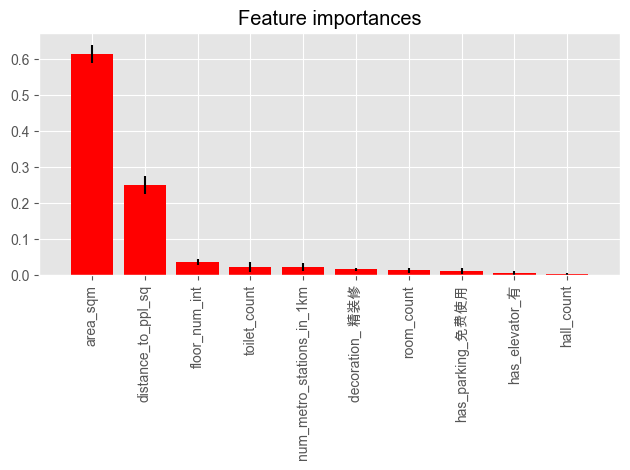

In [202]:
importances = rf_best.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_best.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(len(indices)):
    print("%d. feature %d (%f) - %s" % (f + 1, indices[f], importances[indices[f]], features[indices[f]]))

# Plot the feature importances of the forest

plt.figure()
plt.title("Feature importances")
plt.bar(range(len(indices)), importances[indices], color="r", yerr=std[indices], align="center")
plt.xticks(range(len(indices)), [features[i] for i in indices], rotation='vertical')
plt.xlim([-1, len(indices)])
plt.tight_layout()  # Add this line to improve spacing and avoid overlapping
plt.show()


Check feature importance for best XGBoost

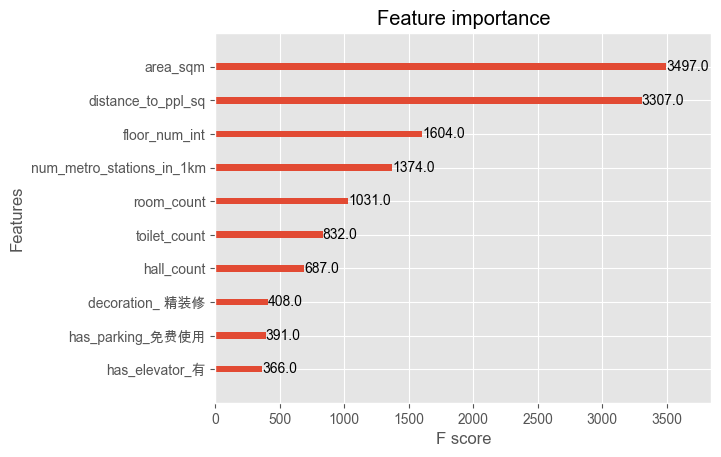

In [203]:
# plot feature importance
xgb.plot_importance(xgb_best)
plt.show()


To further improve performance , try removing some outliers in `area_sqm`, as it is the most important feature, I try to remove apartment that has area >400 as it is not a typical need and in the previous distribution plot we saw few points fell into this region.

In [204]:
filtered_df = residential_one_hot_numeric[residential_one_hot_numeric['area_sqm'] <= 400]
X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split_new(filtered_df,features,target)

In [216]:
print(residential_one_hot_numeric.shape)
print(filtered_df.shape)

(28990, 50)
(28905, 50)


In [205]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the base models
base_models = [
    ('Random Forest', RandomForestRegressor(**rf_best_params,random_state=42)),
    ('XGBoost', xgb.XGBRegressor(**xgb_best_params,random_state=42))
]

# Define the meta-model
meta_model = LinearRegression()

# Perform stacking with the meta-model
stack_reg = StackingRegressor(estimators=base_models, final_estimator=meta_model)

# Fit the stacking model on the training data
stack_reg.fit(X_train_filtered, y_train_filtered)

# Make predictions on the test data
y_pred_filtered = stack_reg.predict(X_test_filtered)

# Calculate evaluation metrics on the test data

regression_metrics_filtered =calculate_regression_metrics(y_test_filtered, y_pred_filtered, 'Remove outlier area>400')
results_df.loc[len(results_df)] = regression_metrics_filtered



In [206]:
print(results_df)

                      Model  Mean Squared Error  Root Mean Squared Error   
0         Linear Regression        2.830890e+07              5320.610995  \
1             Random Forest        1.422363e+07              3771.422470   
2         Gradient Boosting        1.827191e+07              4274.565994   
3            Neural Network        2.840816e+07              5329.930661   
4                   XGBoost        1.419436e+07              3767.540589   
5                       SVM        6.756874e+07              8220.020547   
6         RandomForest_best        1.434872e+07              3787.970432   
8              XGBoost_best        1.418118e+07              3765.790345   
9    Linear Regression-meta        1.376129e+07              3709.620663   
10    Ridge Regression-meta        1.376152e+07              3709.651914   
11  Remove outlier area>400        9.678666e+06              3111.055381   

    Mean Absolute Error  R-Squared  
0           2282.561717   0.605319  
1           1

After 2min 48.2s, got the result

| Model | Mean Squared Error | Root Mean Squared Error | Mean Absolute Error | R-Squared |
|---|---|---|---|---|
| Linear Regression | 2.830890e+07 | 5320.610995 | 2282.561717 | 0.605319 |
| Random Forest | 1.422363e+07 | 3771.422470 | 1392.152518 | 0.801695 |
| Gradient Boosting | 1.827191e+07 | 4274.565994 | 1619.775862 | 0.745254 |
| Neural Network | 2.840816e+07 | 5329.930661 | 2373.200184 | 0.603935 |
| XGBoost | 1.419436e+07 | 3767.540589 | 1416.981084 | 0.802103 |
| SVM | 6.756874e+07 | 8220.020547 | 3277.116254 | 0.057961 |
| RandomForest_best | 1.434872e+07 | 3787.970432 | 1388.029741 | 0.799951 |
| XGBoost_best | 1.418118e+07 | 3765.790345 | 1422.060618 | 0.802287 |
| Linear Regression-meta | 1.376129e+07 | 3709.620663 | 1365.032856 | 0.808141 |
| Ridge Regression-meta | 1.376152e+07 | 3709.651914 | 1365.018571 | 0.808138 |
| Remove outlier area>400 | 9.678666e+06 | 3111.055381 | 1355.573050 | 0.840804 |


The removal of 'outlier' apartment shows better performance in terms of Mean Squared Error, Root Mean Squared Error, Mean Absolute Error, and R-squared compared to the other models. It achieves a lower MSE, RMSE, and MAE, indicating better accuracy, and a higher R-squared value, indicating better predictive power.

In [207]:
residential_one_hot.shape

(28990, 50)

To further improve performnce via feature engineering , add a new feature `property_age` feature. 

In [208]:
# Connect to the database
conn = sqlite3.connect('./db/house_rent_lianjia.db')

# Create a cursor object
c = conn.cursor()

# Query the database and fetch all the data from a table
c.execute("SELECT * FROM sh_compound_buildyear")
data = c.fetchall()

# Convert the fetched data into a DataFrame
compound_buildyear = pd.DataFrame(data, columns=[column[0] for column in c.description])

# Close the cursor and the database connection
c.close()
conn.close()

# Print the DataFrame
compound_buildyear


,compound_name,built_years,number_of_build_years
0,BPC陆家嘴创业街区,"未知年建,2016年建",2
1,MAX未来,2015年建,1
2,TODTOWN天荟,"2020年建,未知年建,2018年建,2019年建",4
3,VIP大厦,2003年建,1
4,V格时代广场,未知年建,1
...,...,...,...
10366,龙馨嘉园,2004年建,1
10367,龚华公寓,"1995年建,1994年建,2004年建",3
10368,龚华新村,"1995年建,1994年建,2004年建",3
10369,龚家宅,"未知年建,1991年建,1990年建,1995年建,1989年建",5


In [209]:

# Extract the earliest build year from the "built_years" column
def extract_earliest_build_year(row):
    years = [int(year[:4]) for year in row.split(',') if '未知' not in year]
    if years:
        return min(years)
    else:
        return np.nan

# Calculate the property age
def calculate_property_age(row):
    earliest_build_year = row['earliest_build_year']
    if not np.isnan(earliest_build_year):
        return 2023 - int(earliest_build_year)
    else:
        return np.nan

# Apply the functions to the DataFrame
compound_buildyear['earliest_build_year'] = compound_buildyear['built_years'].apply(extract_earliest_build_year)
compound_buildyear['property_age'] = compound_buildyear.apply(calculate_property_age, axis=1)

# Convert columns to integers
compound_buildyear['earliest_build_year'] = compound_buildyear['earliest_build_year'].astype('Int64')
compound_buildyear['property_age'] = compound_buildyear['property_age'].astype('Int64')

# Display the updated DataFrame
print(compound_buildyear.columns)


Index(['compound_name', 'built_years', 'number_of_build_years',
       'earliest_build_year', 'property_age'],
      dtype='object')


In [210]:
residential_one_hot.columns

Index(['link', 'house_code', 'district', 'subarea', 'compound_name', 'metro',
       'orientation', 'house_tags', 'facilities', 'house_desc', 'room_count',
       'hall_count', 'toilet_count', 'area_sqm', 'price_float', 'layout',
       'num_metro_stations', 'floor_num_int', 'longitude', 'latitude',
       'facilities_count', 'price_per_sqm', 'area_level', 'bed_liv_room',
       'dist_to_metro', 'num_metro_stations_in_1km', 'distance_to_ppl_sq',
       'has_elevator_无', 'has_elevator_有', 'has_parking_免费使用',
       'has_parking_暂无数据', 'has_parking_租用车位', 'water_type_商水',
       'water_type_暂无数据', 'water_type_民水', 'electricity_type_商电',
       'electricity_type_暂无数据', 'electricity_type_民电', 'gas_无', 'gas_暂无数据',
       'gas_有', 'heating_暂无数据', 'heating_自采暖', 'heating_集中供暖',
       'decoration_ 精装修', 'floor_sec_中楼层', 'floor_sec_低楼层', 'floor_sec_高楼层',
       'has_description_False', 'has_description_True'],
      dtype='object')

In [219]:
# Create a copy of DataFrame to avoid changing the original
df_propertyage = filtered_df.copy()  
df_propertyage['property_age'] = filtered_df['compound_name'].map(compound_buildyear.set_index('compound_name')['property_age'])

print("Number of null value in property_age : ", df_propertyage['property_age'].isnull().sum())


Number of null value in property_age :  3197


(28905, 51)

In [220]:
# Remove rows where 'property_age' is NaN
print(df_propertyage.shape)
df_propertyage.dropna(subset=['property_age'], inplace=True)
print(df_propertyage.shape)


(28905, 51)
(25708, 51)


In [221]:
# Convert boolean columns to numerical form
df_propertyage_numeric = convert_boolean_to_numeric(df_propertyage)

# Calculate correlations
correlations_propertyage = calculate_correlations(df_propertyage_numeric, 'price_float')
print(correlations_propertyage)



Non-Numerical Columns:
Index(['link', 'house_code', 'district', 'subarea', 'compound_name', 'metro',
       'orientation', 'house_tags', 'facilities', 'house_desc', 'layout',
       'area_level', 'bed_liv_room'],
      dtype='object')
price_float                  1.000000
area_sqm                     0.686044
toilet_count                 0.599374
price_per_sqm                0.505784
room_count                   0.444027
floor_num_int                0.407045
hall_count                   0.403808
has_elevator_有               0.314107
decoration_ 精装修              0.244102
num_metro_stations_in_1km    0.240966
has_parking_免费使用             0.225519
has_description_True         0.215841
num_metro_stations           0.176836
gas_有                        0.104186
facilities_count             0.099515
heating_自采暖                  0.099245
has_parking_租用车位             0.096273
floor_sec_低楼层                0.081592
longitude                    0.066251
heating_集中供暖                 0.046649
latit

The correlation value of -0.22 between property_age and the rental price, it indicates a moderate negative correlation. 

As the property_age increases, price_float tends to decrease. In other words, older properties generally have lower prices compared to newer ones.

Let's add property_age to feature sets and assess feature importance for both Random Forest and XGBoost, 

In [222]:
features_new = list(set(features).union(['property_age']))
print(features_new)


['has_elevator_有', 'property_age', 'area_sqm', 'num_metro_stations_in_1km', 'hall_count', 'toilet_count', 'decoration_ 精装修', 'floor_num_int', 'distance_to_ppl_sq', 'room_count', 'has_parking_免费使用']


In [223]:
# Split the data into training and testing sets
X_train_age, X_test_age, y_train_age, y_test_age = train_test_split_new(df_propertyage_numeric,features_new,target)

In [225]:
# fit the choosen model on all available data
stack_reg.fit(X_train_age, y_train_age)

# make a prediction
y_pred_age = stack_reg.predict(X_test_age)


# Calculate evaluation metrics on the test data

regression_metrics_age=calculate_regression_metrics(y_test_age, y_pred_age, 'Add feature property_age')
results_df.loc[len(results_df)] = regression_metrics_age


In [226]:
print(results_df)

                       Model  Mean Squared Error  Root Mean Squared Error   
0          Linear Regression        2.830890e+07              5320.610995  \
1              Random Forest        1.422363e+07              3771.422470   
2          Gradient Boosting        1.827191e+07              4274.565994   
3             Neural Network        2.840816e+07              5329.930661   
4                    XGBoost        1.419436e+07              3767.540589   
5                        SVM        6.756874e+07              8220.020547   
6          RandomForest_best        1.434872e+07              3787.970432   
8               XGBoost_best        1.418118e+07              3765.790345   
9     Linear Regression-meta        1.376129e+07              3709.620663   
10     Ridge Regression-meta        1.376152e+07              3709.651914   
11  Add feature property_age        5.545296e+06              2354.845194   

    Mean Absolute Error  R-Squared  
0           2282.561717   0.605319  
1

The results are :  
| Model | Mean Squared Error | Root Mean Squared Error | Mean Absolute Error | R-Squared |
| --- | --- | --- | --- | --- |
| Linear Regression | 2.830890e+07 | 5320.610995 | 2282.561717 | 0.605319 |
| Random Forest | 1.422363e+07 | 3771.422470 | 1392.152518 | 0.801695 |
| Gradient Boosting | 1.827191e+07 | 4274.565994 | 1619.775862 | 0.745254 |
| Neural Network | 2.840816e+07 | 5329.930661 | 2373.200184 | 0.603935 |
| XGBoost | 1.419436e+07 | 3767.540589 | 1416.981084 | 0.802103 |
| SVM | 6.756874e+07 | 8220.020547 | 3277.116254 | 0.057961 |
| RandomForest_best | 1.434872e+07 | 3787.970432 | 1388.029741 | 0.799951 |
| XGBoost_best | 1.418118e+07 | 3765.790345 | 1422.060618 | 0.802287 |
| Linear Regression-meta | 1.376129e+07 | 3709.620663 | 1365.032856 | 0.808141 |
| Ridge Regression-meta | 1.376152e+07 | 3709.651914 | 1365.018571 | 0.808138 |
| Add feature property_age | 5.545296e+06 | 2354.845194 | 1123.686504 | 0.873762 |


Index(['has_elevator_有', 'property_age', 'area_sqm',
       'num_metro_stations_in_1km', 'hall_count', 'toilet_count',
       'decoration_ 精装修', 'floor_num_int', 'distance_to_ppl_sq', 'room_count',
       'has_parking_免费使用'],
      dtype='object')


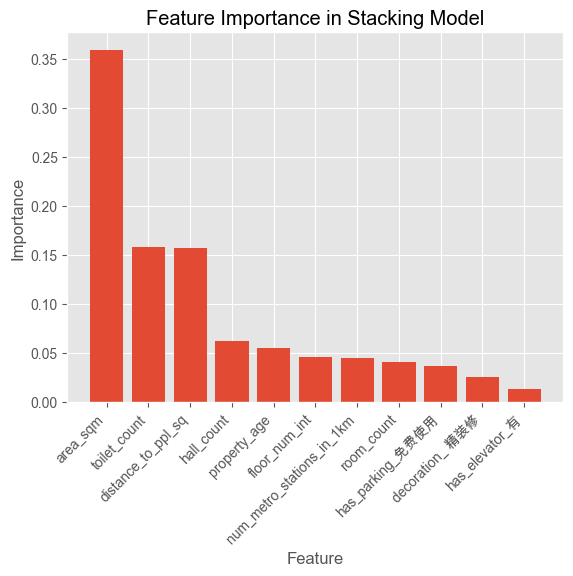

In [227]:
# Train the stacking model with Random Forest and XGBoost as base models and Linear Regression as the meta model
# Make sure you have the trained stacking model object available

# Access the base models from the stacking model
random_forest_base_model = stack_reg.estimators_[0]  # Replace 'stacking_model' with your trained stacking model object
xgboost_base_model = stack_reg.estimators_[1]  # Replace 'stacking_model' with your trained stacking model object

# Extract the feature importances from the Random Forest base model
random_forest_feature_importances = random_forest_base_model.feature_importances_

# Extract the feature importances from the XGBoost base model
xgboost_feature_importances = xgboost_base_model.feature_importances_

# Aggregate the feature importance scores from both base models (e.g., take the average)
average_feature_importances = (random_forest_feature_importances + xgboost_feature_importances) / 2

# Get the feature names
feature_names = X_train_age.columns  # Replace 'X_train' with your training data
print(feature_names)
# Sort the feature importances and feature names in descending order
sorted_indices = np.argsort(average_feature_importances)[::-1]
sorted_feature_importances = average_feature_importances[sorted_indices]
sorted_feature_names = feature_names[sorted_indices]

# Visualize the feature importance scores with feature names
plt.bar(range(len(sorted_feature_importances)), sorted_feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importance in Stacking Model')
plt.xticks(range(len(sorted_feature_names)), sorted_feature_names, rotation=45, ha='right')
plt.show()


In [228]:
print(features_new)

['has_elevator_有', 'property_age', 'area_sqm', 'num_metro_stations_in_1km', 'hall_count', 'toilet_count', 'decoration_ 精装修', 'floor_num_int', 'distance_to_ppl_sq', 'room_count', 'has_parking_免费使用']


In [234]:
# test the model with my real apartment data 
my_apt_data= {
    'has_elevator_有': 0,
    'property_age': 40,
    'area_sqm': 40,
    'num_metro_stations_in_1km': 3,
    'hall_count': 1,
    'toilet_count': 1,
    'decoration_ 精装修': 1,
    'floor_num_int': 5,
    'distance_to_ppl_sq': 4,
    'room_count': 1,
    'has_parking_免费使用': 0
}

# Convert dictionary values to a numpy array and reshape it to be 2D
X_new = np.array(list(my_apt_data.values())).reshape(1, -1)
# Then, use this reshaped data to make your prediction
y = stack_reg.predict(X_new)
print(y)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


[5723.30335672]


The predicted price is 5720 while actually I paid 5500RMB. The difference is 219RMB. I think the accuracy is better than I expected.

Overall, the entire process of selecting models, fine tuning, model stacking, feature enginnering demonstrated the importance of selecting appropriate models, optimizing parameters, and incorporating feature engineering techniques to achieve accurate predictions of house prices.